## Loading data and libraries

In [1]:
## https://www.openml.org/d/246
## https://archive.ics.uci.edu/ml/datasets/Labor+Relations

In [1]:
options (warn = -1)
library(ggplot2)
library(ggthemes)
library(plyr)
library(corrplot)
library(moments)
library(dplyr)
library(randomForest)
library(ROCR)
library(car)
library(caret)

corrplot 0.90 loaded


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


Loading required package: lattice



In [2]:
data = data.frame(read.csv('data/BNG_labor.csv'))

# if something wrong with the relative path, run the absolute path on IBM Cloud
# data = data.frame(read.csv('/home/2021/nyu/fall/xw2113/project/data/BNG_labor.csv'))
# relative path: data = data.frame(read.csv('data/BNG_labor.csv'))

## Data size and structure

In [5]:
dim(data)

[1] 1000000      17

In [6]:
head(data)

,duration,wage.increase.first.year,wage.increase.second.year,wage.increase.third.year,cost.of.living.adjustment,working.hours,pension,standby.pay,shift.differential,education.allowance,statutory.holidays,vacation,longterm.disability.assistance,contribution.to.dental.plan,bereavement.assistance,contribution.to.health.plan,class
,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2,5.254518,2.053763,5.000000,none,37.24529,empl_contr,2.000000,3.0000,yes,11.000000,generous,yes,half,yes,full,good
2,2,2.675478,4.562002,2.384273,none,38.21172,none,2.000000,1.9247,no,9.514273,average,yes,full,yes,full,bad
3,2,4.366755,5.254781,5.000000,none,40.00000,empl_contr,2.000000,5.0000,yes,11.000000,below_average,yes,half,yes,full,good
4,2,2.961461,4.517101,5.000000,none,40.00000,empl_contr,2.708944,3.0000,no,12.000000,average,yes,half,yes,full,good
5,2,3.799157,4.563729,5.000000,tcf,39.00000,none,2.000000,3.0000,no,11.000000,average,no,half,no,none,bad
6,2,5.952678,4.000000,2.339589,none,40.00000,empl_contr,2.000000,3.0000,no,12.000000,average,yes,half,yes,full,good


In [7]:
str(data)

'data.frame':	1000000 obs. of  17 variables:
 $ duration                      : int  2 2 2 2 2 2 1 3 2 1 ...
 $ wage.increase.first.year      : num  5.25 2.68 4.37 2.96 3.8 ...
 $ wage.increase.second.year     : num  2.05 4.56 5.25 4.52 4.56 ...
 $ wage.increase.third.year      : num  5 2.38 5 5 5 ...
 $ cost.of.living.adjustment     : chr  "none" "none" "none" "none" ...
 $ working.hours                 : num  37.2 38.2 40 40 39 ...
 $ pension                       : chr  "empl_contr" "none" "empl_contr" "empl_contr" ...
 $ standby.pay                   : num  2 2 2 2.71 2 ...
 $ shift.differential            : num  3 1.92 5 3 3 ...
 $ education.allowance           : chr  "yes" "no" "yes" "no" ...
 $ statutory.holidays            : num  11 9.51 11 12 11 ...
 $ vacation                      : chr  "generous" "average" "below_average" "average" ...
 $ longterm.disability.assistance: chr  "yes" "yes" "yes" "yes" ...
 $ contribution.to.dental.plan   : chr  "half" "full" "half" "half" ...


## check missing data

In [8]:
##First of all, I would like to see which features contain missing values.

colSums(is.na(data))
NAcol <- which(colSums(is.na(data)) > 0)
print(NAcol)

duration       wage.increase.first.year 
                             0                              0 
     wage.increase.second.year       wage.increase.third.year 
                             0                              0 
     cost.of.living.adjustment                  working.hours 
                             0                              0 
                       pension                    standby.pay 
                             0                              0 
            shift.differential            education.allowance 
                             0                              0 
            statutory.holidays                       vacation 
                             0                              0 
longterm.disability.assistance    contribution.to.dental.plan 
                             0                              0 
        bereavement.assistance    contribution.to.health.plan 
                             0                              0 
                         class 
                             0

named integer(0)


## Label encoding

In [3]:
#checking how many numerical features and how many categorical features.

Charcol <- names(data[,sapply(data, is.character)])
print(Charcol)

[1] "cost.of.living.adjustment"      "pension"                       
[3] "education.allowance"            "vacation"                      
[5] "longterm.disability.assistance" "contribution.to.dental.plan"   
[7] "bereavement.assistance"         "contribution.to.health.plan"   
[9] "class"                         


In [4]:
Numcol <- names(data[,sapply(data, is.numeric)])
print(Numcol)

[1] "duration"                  "wage.increase.first.year" 
[3] "wage.increase.second.year" "wage.increase.third.year" 
[5] "working.hours"             "standby.pay"              
[7] "shift.differential"        "statutory.holidays"       


### Label encoding for categorical features.

### There are 8 categorical features.
#### if feature is ordinal, label encoding.
#### else, just factor.

### 1. cost.of.living.adjustment

In [11]:
#types of cost of living adjustment
table(data$cost.of.living.adjustment)


  none     tc    tcf 
717187 132291 150522 

In [5]:
#Not ordinal, so converting into factors
data$cost.of.living.adjustment <- as.factor(data$cost.of.living.adjustment)
sum(table(data$cost.of.living.adjustment))

[1] 1000000

### 2. pension: employer contributions to pension plan

In [13]:
#types of pension
table(data$pension)


empl_contr       none   ret_allw 
    719227     197740      83033 

In [6]:
#Not ordinal, so converting into factors
data$pension <- as.factor(data$pension)
sum(table(data$pension))

[1] 1000000

### 3. education.allowance

In [15]:
#types of education allowance
table(data$education.allowance)


    no    yes 
765843 234157 

In [7]:
#Ordinal, so label encoding
data$education.allowance <- as.integer(as.character(revalue(data$education.allowance, c('no'=0, 'yes'=1))))
table(data$education.allowance)


     0      1 
765843 234157 

In [17]:
sum(table(data$education.allowance))

[1] 1000000

### 4. vacation: number of paid vacation days

In [18]:
#types of vacation
table(data$vacation)


      average below_average      generous 
       319866        400754        279380 

In [8]:
#Ordinal, so label encoding
data$vacation <- as.integer(as.character(revalue(data$vacation, c('average'=1, 'below_average'=2, 'generous'=3))))
table(data$vacation)


     1      2      3 
319866 400754 279380 

In [20]:
sum(table(data$vacation))

[1] 1000000

### 5. longterm.disability.assistance: employer's help during employee longterm disability

In [21]:
#types of longterm disability assistance
table(data$longterm.disability.assistance)


    no    yes 
151507 848493 

In [9]:
#Ordinal, so label encoding
data$longterm.disability.assistance <- as.integer(as.character(revalue(data$longterm.disability.assistance, c('no'=0, 'yes'=1))))
table(data$longterm.disability.assistance)


     0      1 
151507 848493 

In [10]:
sum(table(data$longterm.disability.assistance))

[1] 1000000

### 6. contribution.to.dental.plan: employers contribution towards the dental plan

In [11]:
#types of contribution to dental plan
table(data$contribution.to.dental.plan)


  full   half   none 
238657 582600 178743 

In [12]:
#Ordinal, so label encoding
data$contribution.to.dental.plan <- as.integer(as.character(revalue(data$contribution.to.dental.plan, c('none'=0, 'half'=1, 'full'=2))))
table(data$contribution.to.dental.plan)


     0      1      2 
178743 582600 238657 

In [13]:
sum(table(data$contribution.to.dental.plan))

[1] 1000000

### 7. bereavement.assistance: employer's financial contribution towards the covering the costs of bereavement

In [14]:
#types of bereavement assistance
table(data$bereavement.assistance)


    no    yes 
 76305 923695 

In [15]:
#Ordinal, so label encoding
data$bereavement.assistance <- as.integer(as.character(revalue(data$bereavement.assistance, c('no'=0, 'yes'=1))))
table(data$bereavement.assistance)


     0      1 
 76305 923695 

In [16]:
sum(table(data$bereavement.assistance))

[1] 1000000

### 8. contribution.to.health.plan: employer's contribution towards the health plan

In [17]:
#types of contribution to health paln
table(data$contribution.to.health.plan)


  full   half   none 
662071 204877 133052 

In [18]:
#Ordinal, so label encoding
data$contribution.to.health.plan <- as.integer(as.character(revalue(data$contribution.to.health.plan, c('none'=0, 'half'=1, 'full'=2))))
table(data$contribution.to.health.plan)


     0      1      2 
133052 204877 662071 

In [19]:
sum(table(data$contribution.to.health.plan))

[1] 1000000

### response variable

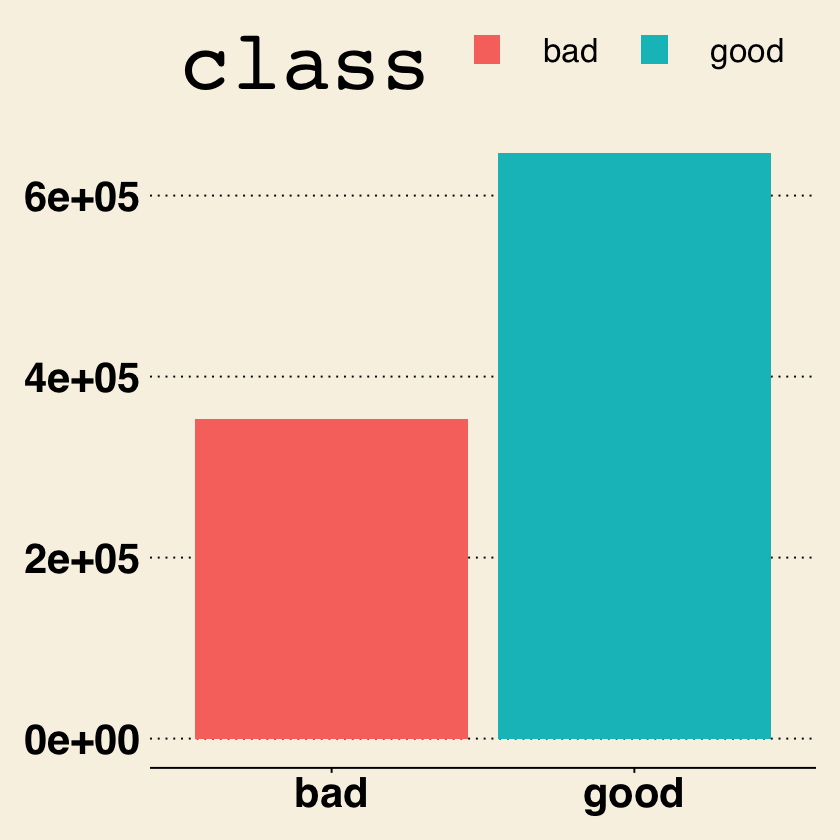

In [21]:
ggplot(data, aes(x=class, fill = class)) + 
    geom_bar() + 
    theme_wsj() +
    theme(text = element_text(size = 25))


In [22]:
# add a new feature: labor.relation to help eda

data$labor.relation <- ifelse(data$class=='good', "good relation", "bad relation")
data$labor.relation <- as.factor(data$class)

# label encoding the response variable
data$class <- as.integer(as.character(revalue(data$class, c('bad'=0, 'good'=1))))
table(data$class)


     0      1 
353000 647000 

In [ ]:
str(data)

In [36]:
summary(data)

# The mean wage keeps increase from first year to third year.
# Someone was deducted from their wages in the third year.
# About 70% people do not have cost of living adjustment.
# About 70% employers contribute to their employee's pension.
# The data size is 1000,000, 353000 bad relations and 647000 good relations.


## Question:
#unblanced response variable, under sample?
# Can we add wage.increase.first.year+wage.increase.second.year+wage.increase.third.year to create a new feature?


    duration     wage.increase.first.year wage.increase.second.year
 Min.   :1.000   Min.   :1.662            Min.   :1.231            
 1st Qu.:2.000   1st Qu.:2.697            1st Qu.:3.119            
 Median :2.000   Median :3.850            Median :4.000            
 Mean   :2.152   Mean   :3.837            Mean   :3.982            
 3rd Qu.:3.000   3rd Qu.:4.540            3rd Qu.:4.547            
 Max.   :3.000   Max.   :9.197            Max.   :9.466            
 wage.increase.third.year cost.of.living.adjustment working.hours  
 Min.   :-1.370           none:717187               Min.   :23.56  
 1st Qu.: 5.000           tc  :132291               1st Qu.:37.46  
 Median : 5.000           tcf :150522               Median :39.00  
 Mean   : 4.654                                     Mean   :38.21  
 3rd Qu.: 5.000                                     3rd Qu.:40.00  
 Max.   : 6.862                                     Max.   :46.14  
       pension        standby.pay     shift.diff

### downsample，first we need to split data.

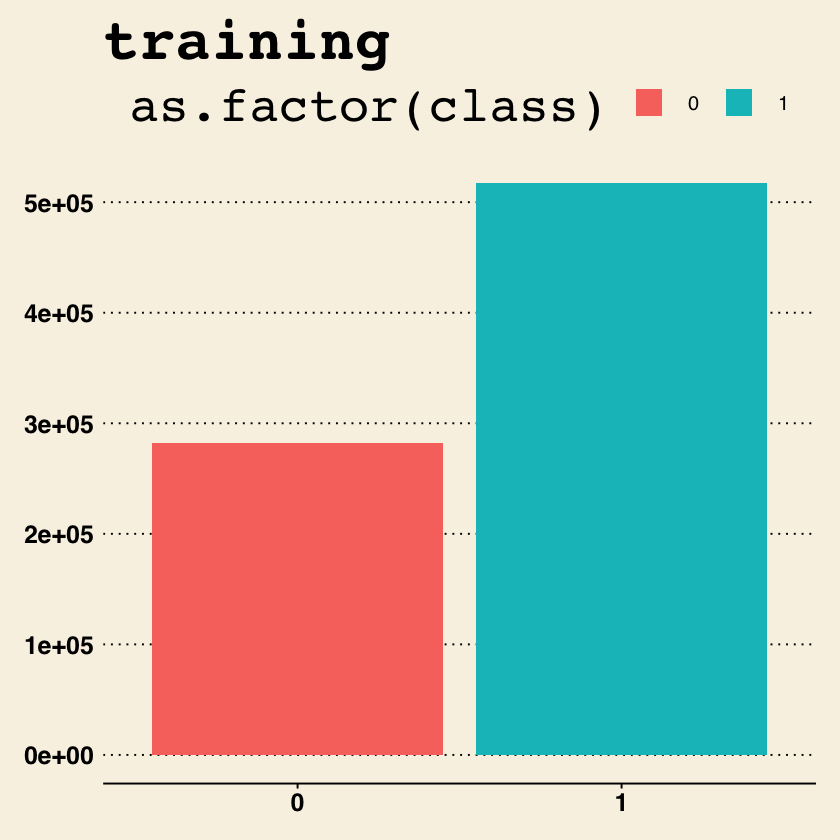

null device 
          1

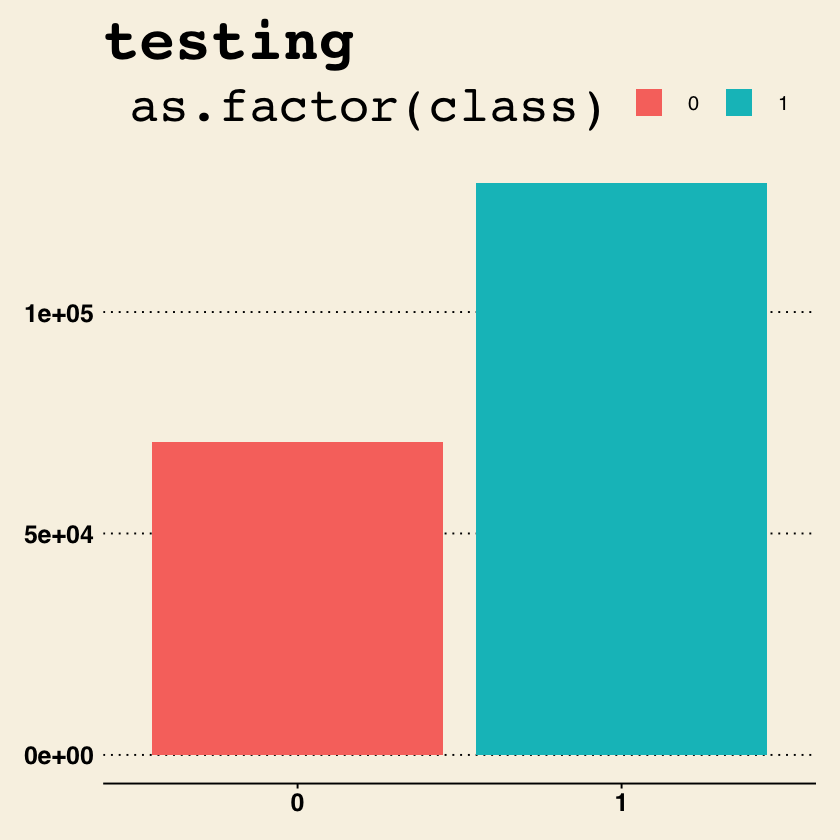

In [23]:
#split data int train and test


set.seed(43)
index <-  sort(sample(nrow(data), nrow(data)*.8))
train <- data[index,]
test <-  data[-index,]

ggplot(train, aes(x=as.factor(class), fill = as.factor(class))) + 
    geom_bar() + 
    theme_wsj() +
    ggtitle("training") + 
    theme(text = element_text(size = 15))

ggplot(test, aes(x=as.factor(class), fill = as.factor(class))) + 
    geom_bar() + 
    theme_wsj() +
    ggtitle("testing") + 
    theme(text = element_text(size = 15))

dev.off()

In [25]:
#downsample
subtrain0 <- train[train$class == 0,] #controls
row.name <- rownames(train[train$class == 1,])

set.seed(43)
resample <- sample(row.name, nrow(subtrain0), replace = F) #resampling
subtrain1 <- train[resample,]  #cases

train <- rbind(subtrain0,subtrain1)

#shuffle
set.seed(42)
rows <- sample(nrow(train))
train <- train[rows, ]

dim(train)

[1] 564474     18

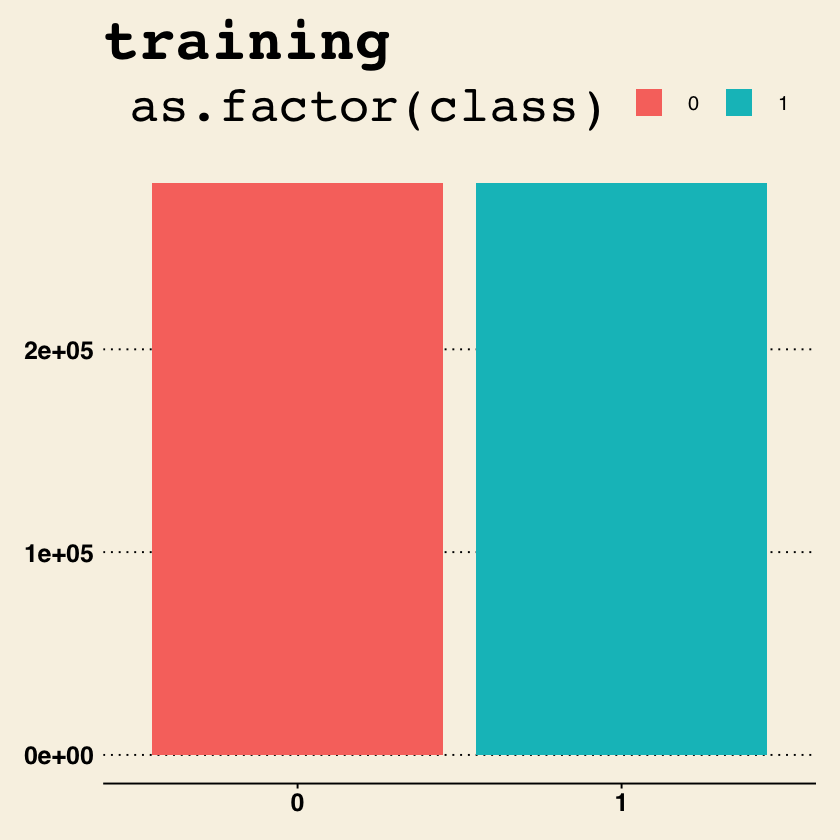

In [40]:
ggplot(train, aes(x=as.factor(class), fill = as.factor(class))) + 
    geom_bar() + 
    theme_wsj() +
    ggtitle("training") +
    theme(text = element_text(size = 15))

### Exploratory analysis and visualization of all variables

### 1. duration: duration of agreement

In [41]:
summary(as.factor(train$duration))

1      2      3 
112651 273782 178041

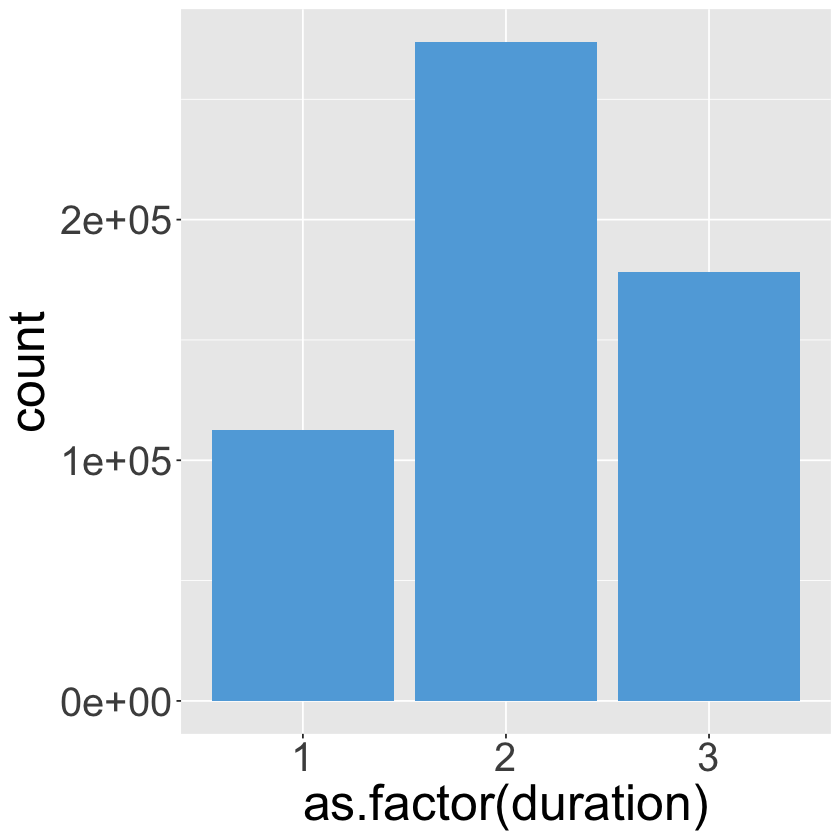

In [42]:
ggplot(data=train, aes(x=as.factor(duration))) +
geom_histogram(stat='count', fill = "#60AADD") +
theme(text = element_text(size = 30))

In [43]:
# correlation test
chisq.test(train$labor.relation, as.factor(train$duration),
               correct = F)

## Since we get a p-Value less than the significance level of 0.05, 
## we reject the null hypothesis and conclude that the two variables are in fact dependent.


	Pearson's Chi-squared test

data:  train$labor.relation and as.factor(train$duration)
X-squared = 15206, df = 2, p-value < 2.2e-16


In [44]:
train %>%
    group_by(labor.relation) %>% 
    summarise(mean = mean(duration), sd = sd(duration),
                    median = median(duration), IQR = IQR(duration))

labor.relation,mean,sd,median,IQR
<fct>,<dbl>,<dbl>,<int>,<dbl>
bad,2.000379,0.7151111,2,2
good,2.231306,0.6819635,2,1


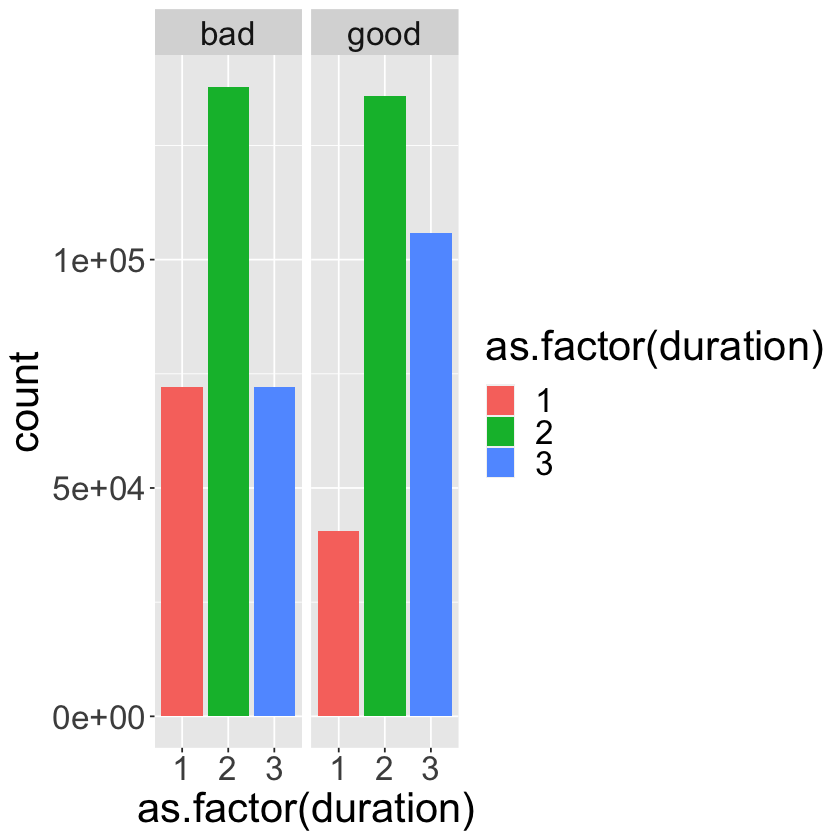

In [45]:
train %>% 
    ggplot(
        aes(x= as.factor(duration), fill= as.factor(duration))) + 
    geom_bar() +  
    facet_wrap(~ labor.relation) +
    theme(text = element_text(size = 25))

# higher duration is more likely to be a good relation.

### 2. wage.increase.first.year

In [46]:
summary(train$wage.increase.first.year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.802   2.492   3.669   3.648   4.498   9.197 

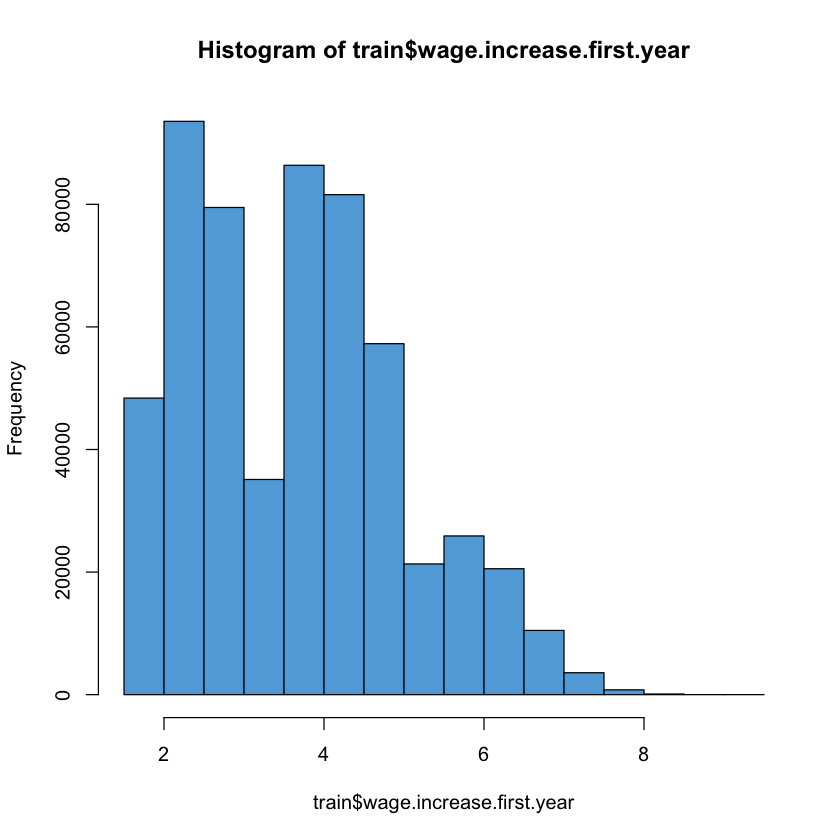

In [47]:
hist(train$wage.increase.first.year, col = "#60AADD")

In [48]:
print(paste("skewness: ", skewness(train$wage.increase.first.year)))
print(paste("kurtosis: ", kurtosis(train$wage.increase.first.year)))

[1] "skewness:  0.489715395042551"
[1] "kurtosis:  2.51519376554725"


#### skewness value is positive, right-skewed.

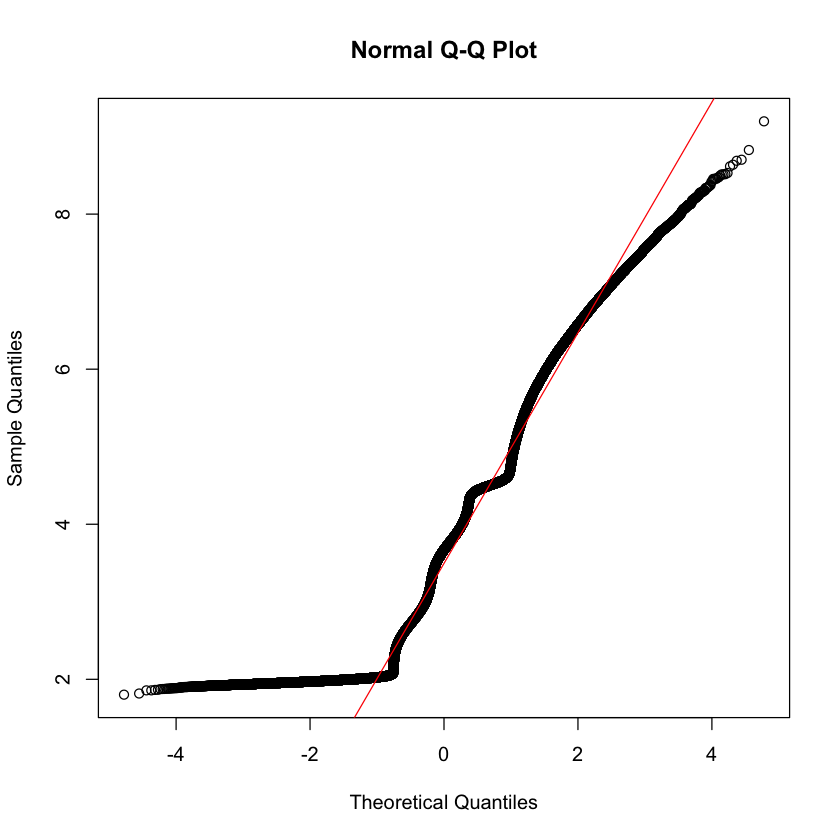

In [49]:
qqnorm(train$wage.increase.first.year)
qqline(train$wage.increase.first.year, col='red')

In [50]:
wilcox.test(train$wage.increase.first.year ~ train$labor.relation, mu=0,
            alternative = "two.sided",
            conf.level= 0.95,
            var.equal = F)


	Wilcoxon rank sum test with continuity correction

data:  train$wage.increase.first.year by train$labor.relation
W = 1.7288e+10, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [51]:
train %>%
    group_by(labor.relation) %>% 
    summarise(mean = mean(wage.increase.first.year), sd = sd(wage.increase.first.year),
                    median = median(wage.increase.first.year), IQR = IQR(wage.increase.first.year))

labor.relation,mean,sd,median,IQR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
bad,3.007749,1.079638,2.740177,1.740323
good,4.287386,1.251782,4.432702,1.409420


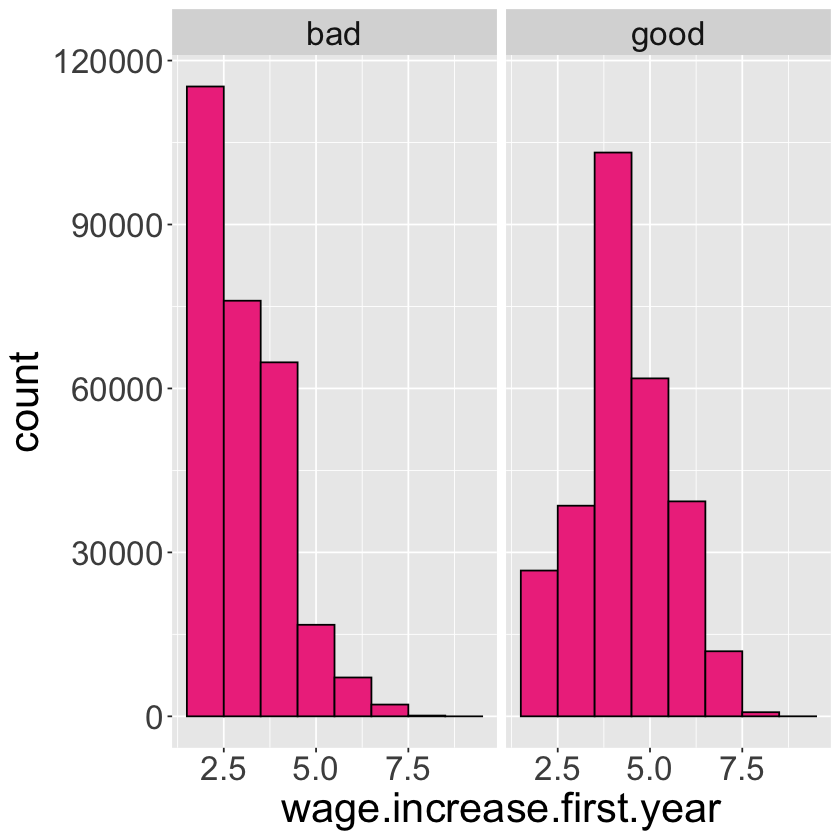

In [53]:
train %>% 
    ggplot(
        aes(x= wage.increase.first.year, fill= wage.increase.first.year)) + 
    geom_histogram(binwidth = 1, color ="black", fill = "violetred2") + 
    facet_wrap(~ labor.relation)+
    theme(text = element_text(size = 25))

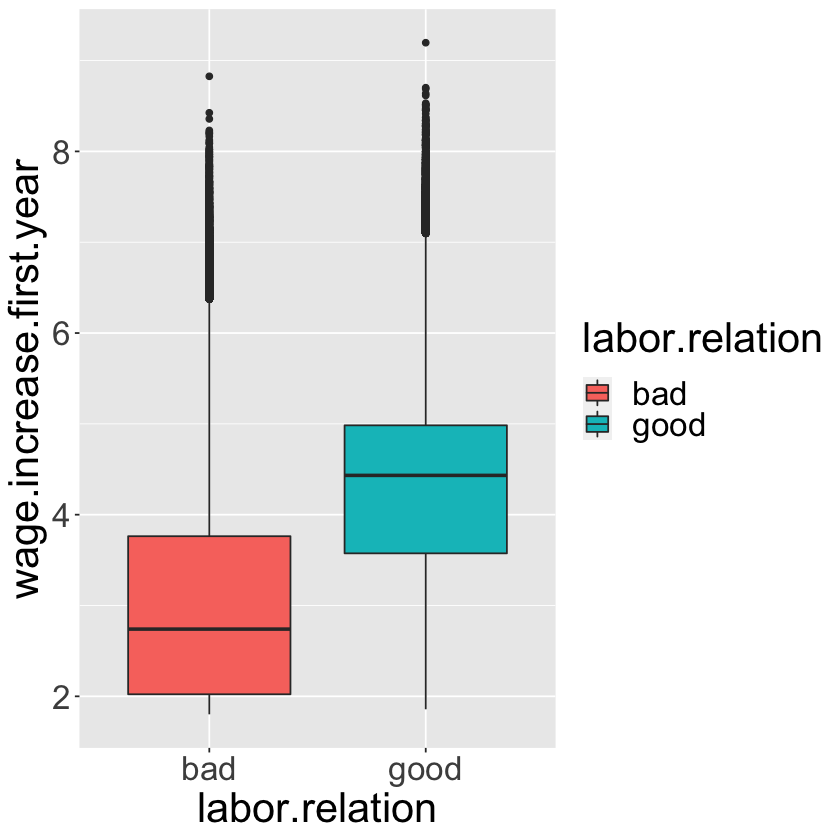

In [54]:
ggplot(train, aes(labor.relation,wage.increase.first.year,fill=labor.relation)) +
geom_boxplot() +
theme(text = element_text(size = 25))

In [55]:
# in the bad relation, most people have a small salary increase in the first year.
# good relation increase salary more than bad relation.

### 3. wage.increase.second.year

In [56]:
summary(train$wage.increase.second.year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.231   3.004   4.000   3.897   4.518   8.751 

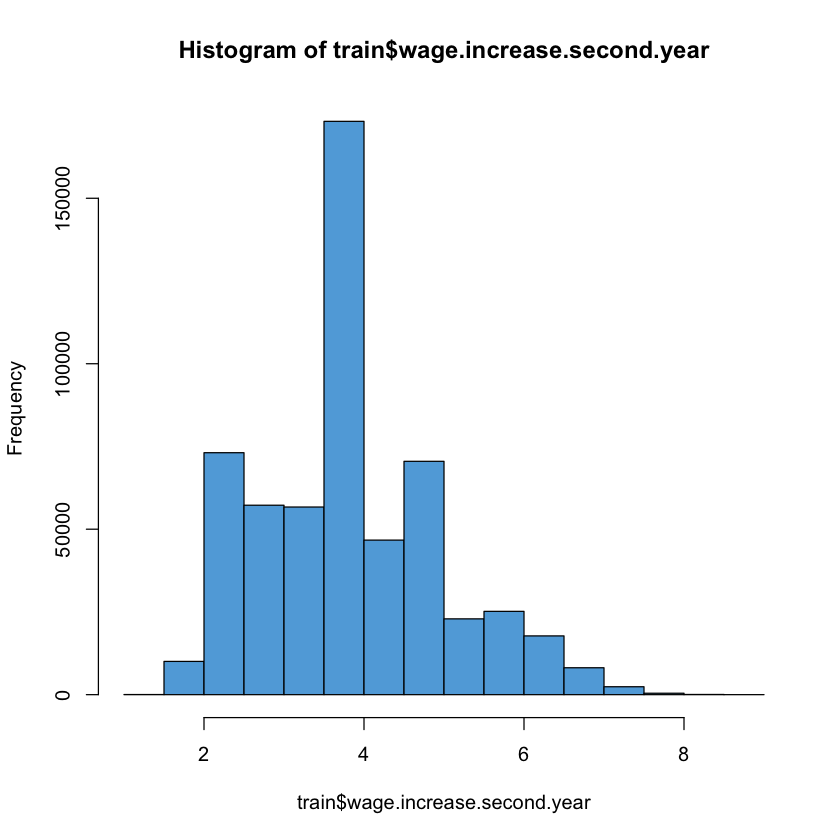

In [57]:
hist(train$wage.increase.second.year, col = "#60AADD")

In [58]:
print(paste("skewness: ", skewness(train$wage.increase.second.year)))
print(paste("kurtosis: ", kurtosis(train$wage.increase.second.year)))

[1] "skewness:  0.332951708469009"
[1] "kurtosis:  2.93742934544308"


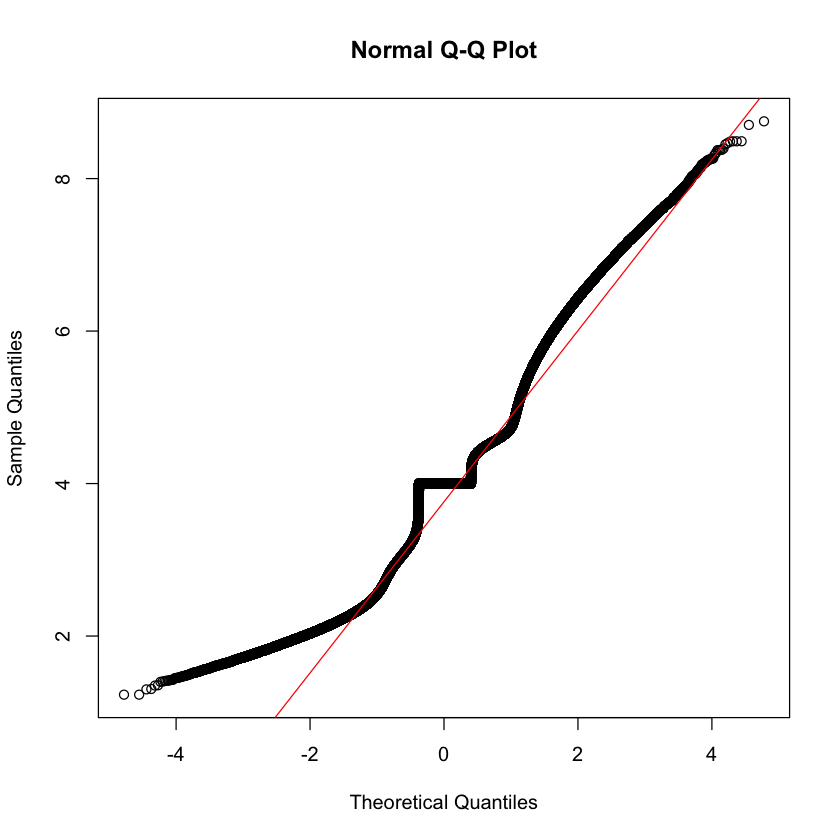

In [59]:
qqnorm(train$wage.increase.second.year)
qqline(train$wage.increase.second.year, col='red')

In [60]:
wilcox.test(train$wage.increase.second.year ~ train$labor.relation, mu=0,
            alternative = "two.sided",
            conf.level= 0.95,
            var.equal = F)


	Wilcoxon rank sum test with continuity correction

data:  train$wage.increase.second.year by train$labor.relation
W = 2.7493e+10, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [61]:
train %>%
    group_by(labor.relation) %>% 
    summarise(mean = mean(wage.increase.second.year), sd = sd(wage.increase.second.year),
                    median = median(wage.increase.second.year), IQR = IQR(wage.increase.second.year))

# median both are 4

labor.relation,mean,sd,median,IQR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
bad,3.610743,1.142265,4,1.416431
good,4.183506,1.036436,4,0.601645


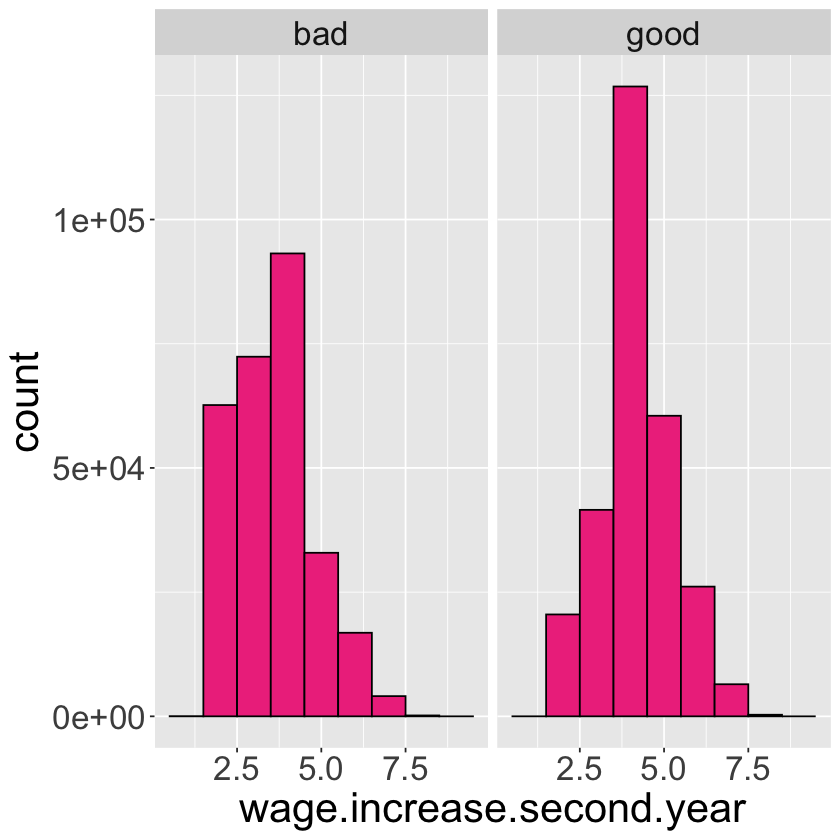

In [62]:
train %>% 
    ggplot(
        aes(x= wage.increase.second.year, fill= wage.increase.second.year)) + 
    geom_histogram(binwidth = 1, color ="black", fill = "violetred2") + 
    facet_wrap(~ labor.relation)+
    theme(text = element_text(size = 25))

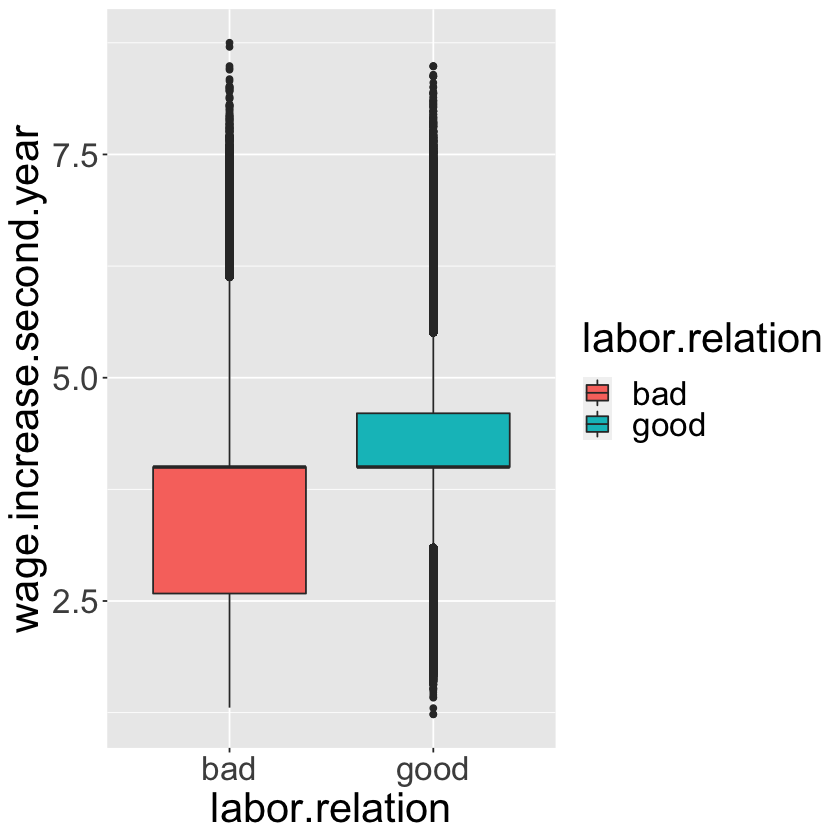

In [63]:
ggplot(train, aes(labor.relation, wage.increase.second.year, fill=labor.relation)) +
geom_boxplot() +
theme(text = element_text(size = 25))

### 4. wage.increase.third.year

In [64]:
summary(train$wage.increase.third.year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.5809  5.0000  5.0000  4.5954  5.0000  6.5161 

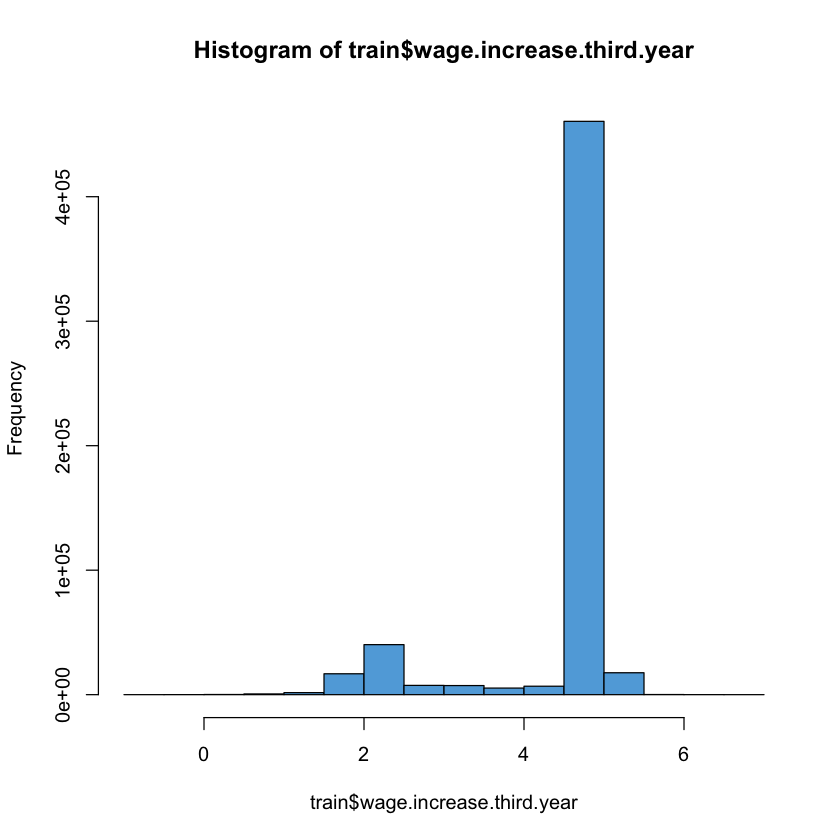

In [65]:
hist(train$wage.increase.third.year, col = "#60AADD")

In [66]:
print(paste("skewness: ", skewness(train$wage.increase.third.year)))
print(paste("kurtosis: ", kurtosis(train$wage.increase.third.year)))

[1] "skewness:  -2.19760862023114"
[1] "kurtosis:  6.17932028862291"


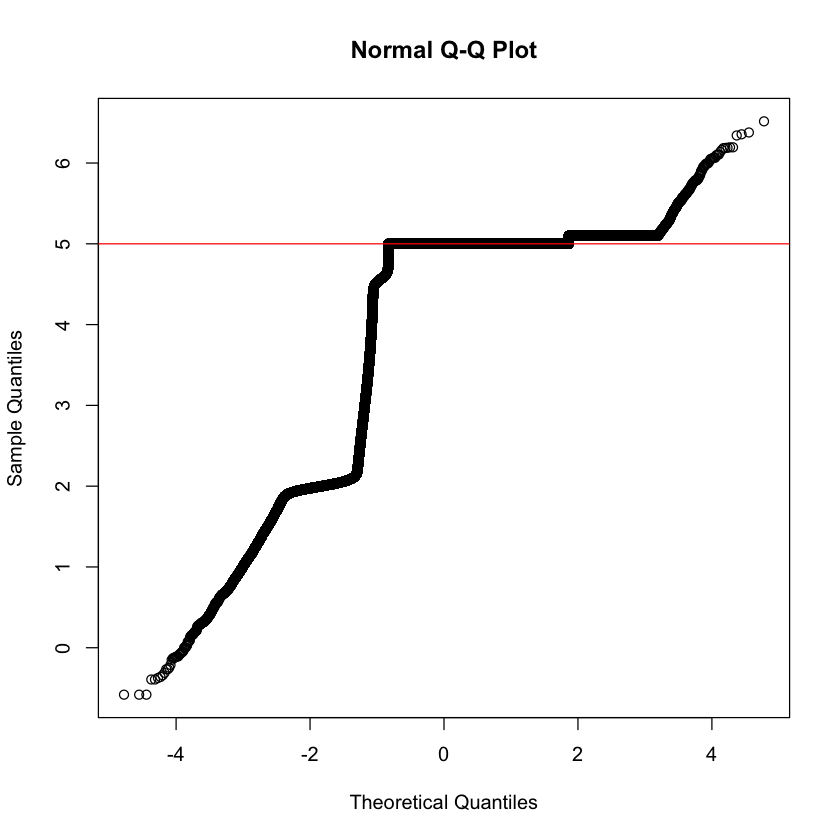

In [67]:
qqnorm(train$wage.increase.third.year)
qqline(train$wage.increase.third.year, col='red')

In [68]:
wilcox.test(train$wage.increase.third.year ~ train$labor.relation, mu=0,
            alternative = "two.sided",
            conf.level= 0.95,
            var.equal = F)


	Wilcoxon rank sum test with continuity correction

data:  train$wage.increase.third.year by train$labor.relation
W = 3.5289e+10, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [69]:
train %>%
    group_by(labor.relation) %>% 
    summarise(mean = mean(wage.increase.third.year), sd = sd(wage.increase.third.year),
                    median = median(wage.increase.third.year), IQR = IQR(wage.increase.third.year))

labor.relation,mean,sd,median,IQR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
bad,4.393593,1.161208,5,0
good,4.797146,0.644982,5,0


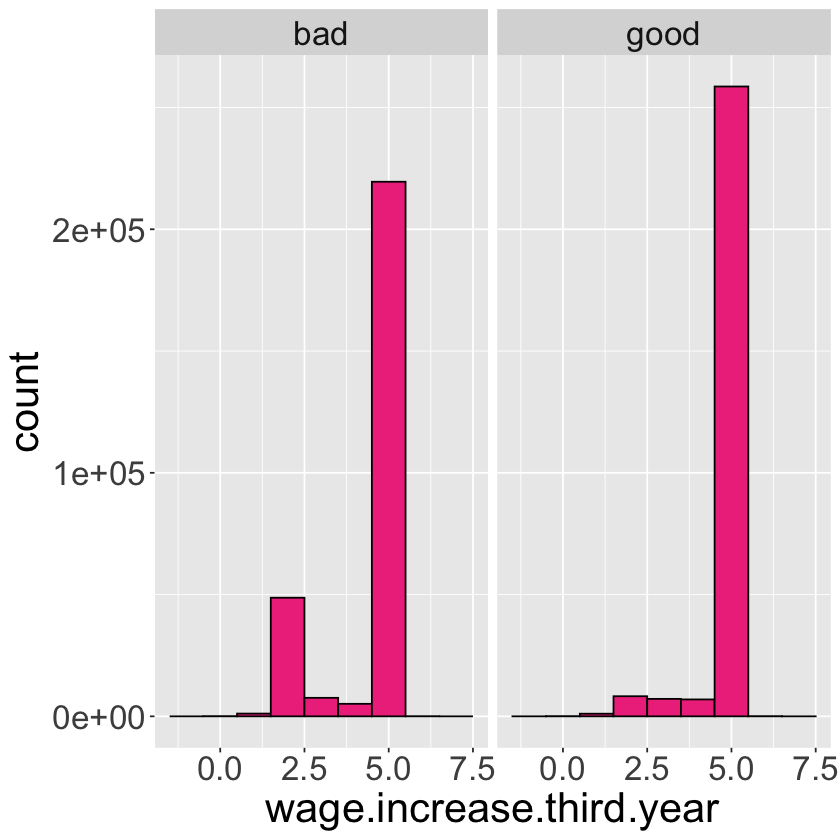

In [70]:
train %>% 
    ggplot(
        aes(x= wage.increase.third.year, fill= wage.increase.third.year)) + 
    geom_histogram(binwidth = 1, color ="black", fill = "violetred2") + 
    facet_wrap(~ labor.relation)+
    theme(text = element_text(size = 25)) 

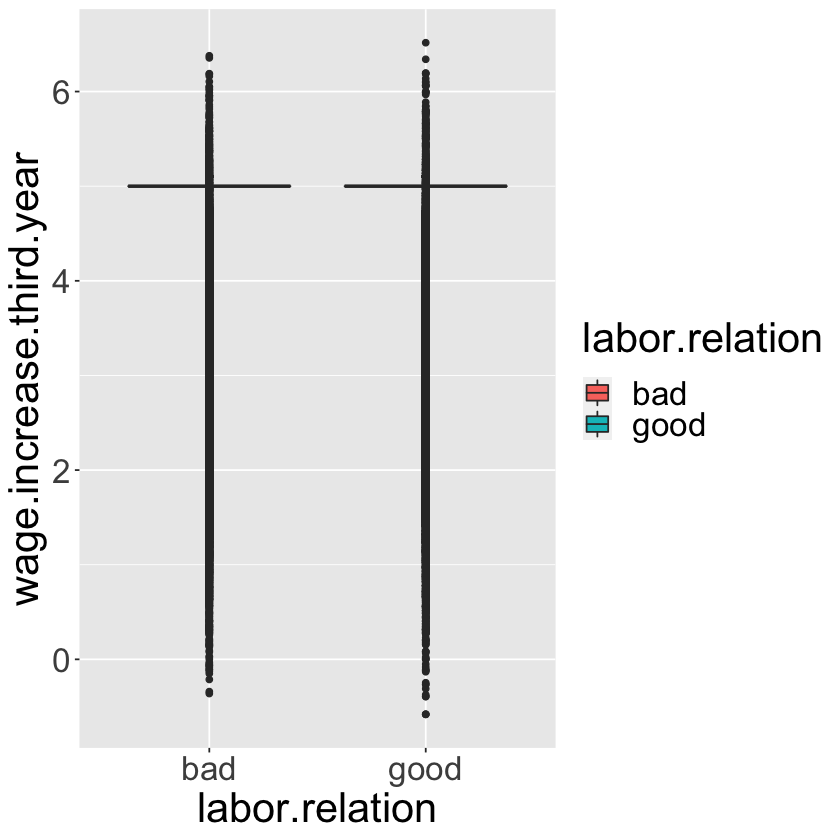

In [71]:
ggplot(train, aes(labor.relation, wage.increase.third.year, fill=labor.relation)) +
geom_boxplot() +
theme(text = element_text(size = 25))

### 5. cost.of.living.adjustment

In [72]:
summary(train$cost.of.living.adjustment)

none     tc    tcf 
399511  90283  74680

In [73]:
# correlation test
chisq.test(train$labor.relation, train$cost.of.living.adjustment,
               correct = F)


	Pearson's Chi-squared test

data:  train$labor.relation and train$cost.of.living.adjustment
X-squared = 49428, df = 2, p-value < 2.2e-16


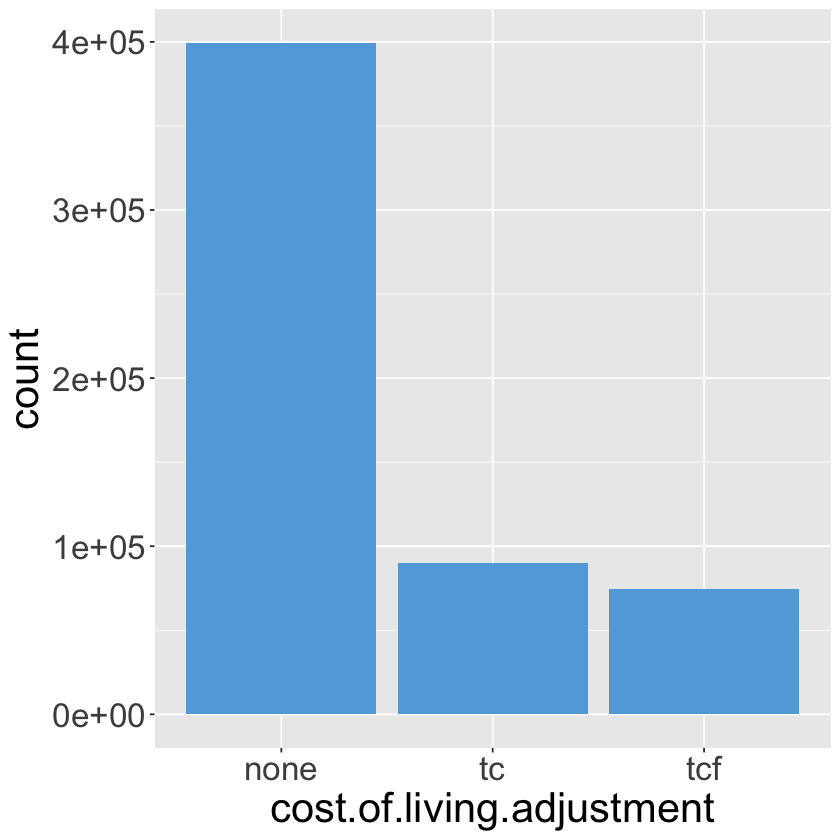

In [74]:
ggplot(data=train, aes(cost.of.living.adjustment)) +
geom_histogram(stat='count', fill = "#60AADD") +
theme(text = element_text(size = 25))

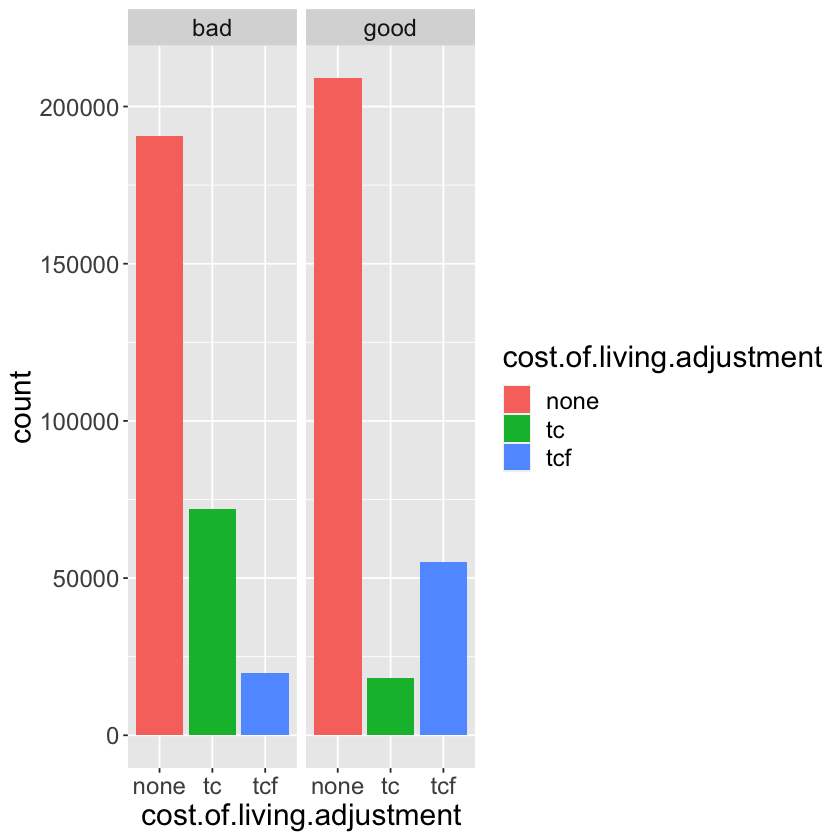

In [75]:
train %>% 
    ggplot(
        aes(x= cost.of.living.adjustment, fill= cost.of.living.adjustment)) + 
    geom_bar() +  
    facet_wrap(~ labor.relation)+
    theme(text = element_text(size = 18))

# good relations have more tcf.

### 6. working.hours

In [78]:
summary(train$working.hours)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  23.56   37.59   40.00   38.38   40.00   46.14 

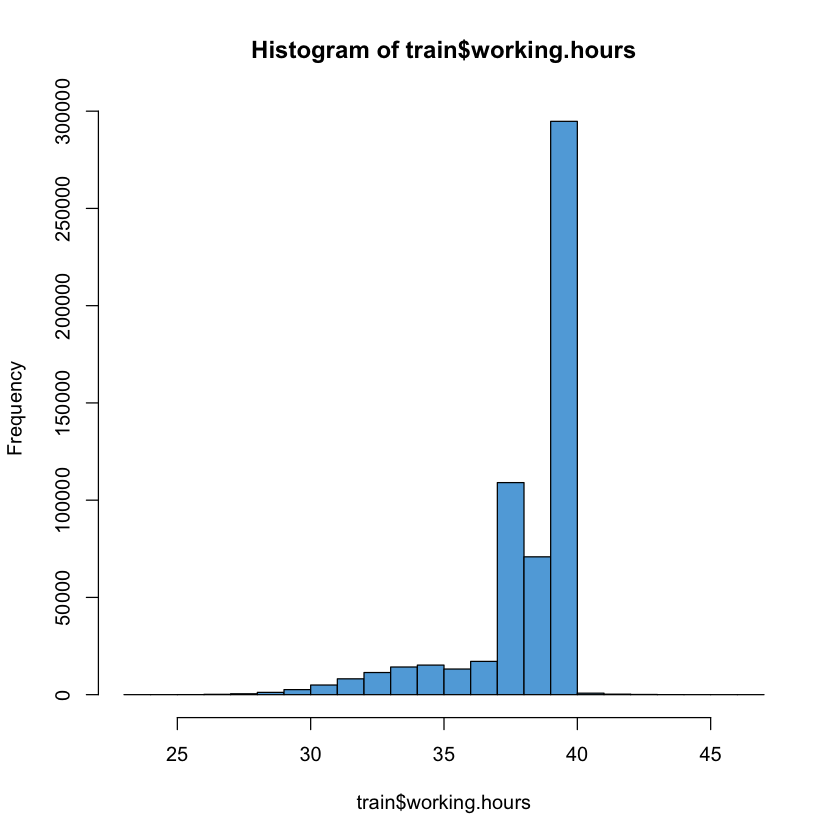

In [79]:
hist(train$working.hours, col = "#60AADD")

In [80]:
print(paste("skewness: ", skewness(train$working.hours)))
print(paste("kurtosis: ", kurtosis(train$working.hours)))

[1] "skewness:  -1.80496172778927"
[1] "kurtosis:  6.13687027090064"


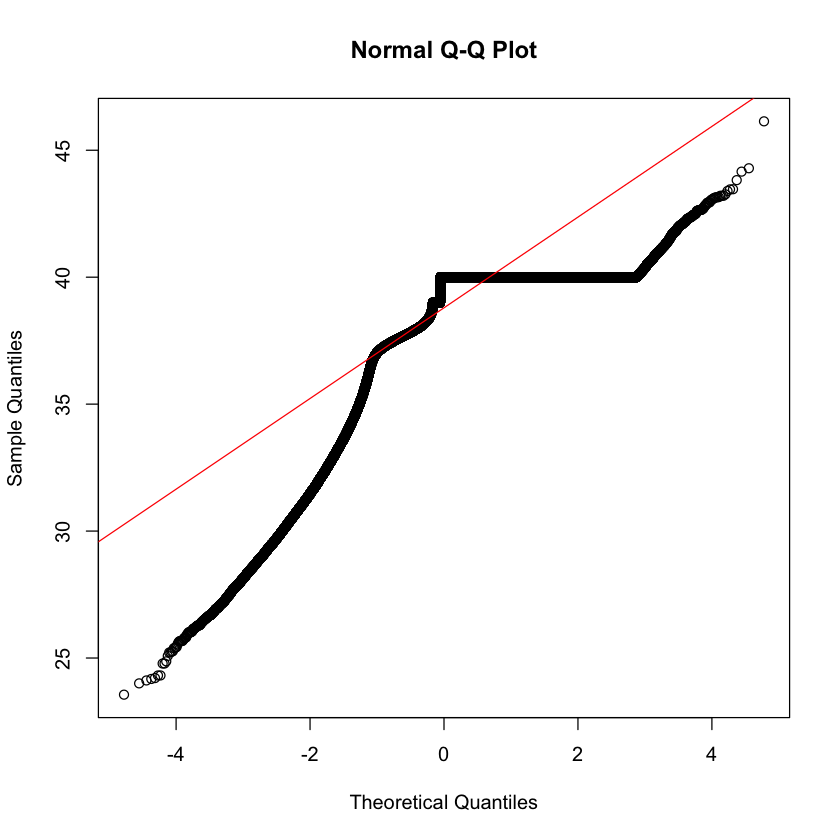

In [81]:
qqnorm(train$working.hours)
qqline(train$working.hours, col='red')

In [82]:
wilcox.test(train$working.hours ~ train$labor.relation, mu=0,
            alternative = "two.sided",
            conf.level= 0.95,
            var.equal = F)


	Wilcoxon rank sum test with continuity correction

data:  train$working.hours by train$labor.relation
W = 5.0151e+10, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [83]:
train %>%
    group_by(labor.relation) %>% 
    summarise(mean = mean(working.hours), sd = sd(working.hours),
                    median = median(working.hours), IQR = IQR(working.hours))

labor.relation,mean,sd,median,IQR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
bad,38.98010,1.733843,40.00000,1.951574
good,37.78507,2.682284,38.19545,2.941787


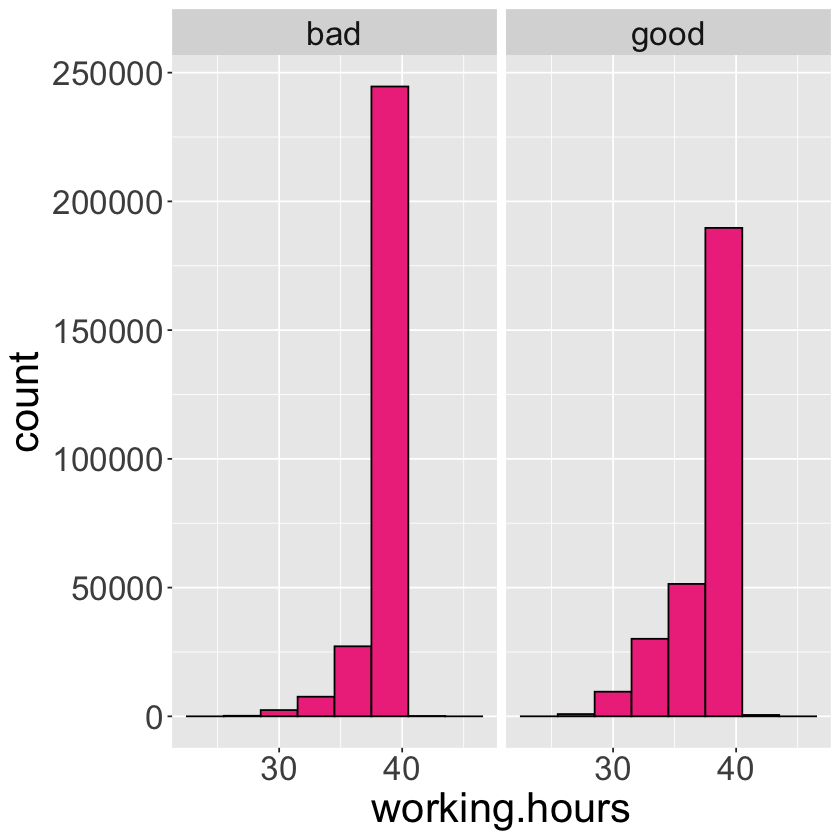

In [84]:
train %>% 
    ggplot(
        aes(x= working.hours, fill= working.hours)) + 
    geom_histogram(binwidth = 3, color ="black", fill = "violetred2") + 
    facet_wrap(~ labor.relation)+
    theme(text = element_text(size = 25))

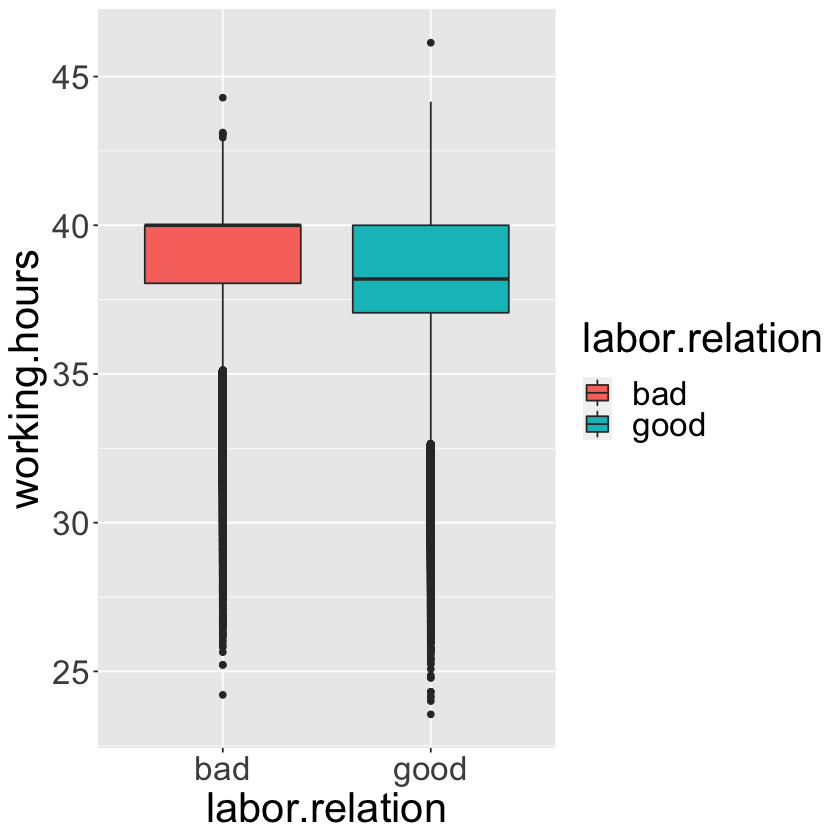

In [85]:
ggplot(train, aes(labor.relation, working.hours, fill=labor.relation)) + 
geom_boxplot() +
theme(text = element_text(size = 25))

### 7. pension

In [86]:
summary(train$pension)

empl_contr       none   ret_allw 
    358623     154957      50894

In [87]:
chisq.test(train$pension, train$labor.relation, correct = F)


	Pearson's Chi-squared test

data:  train$pension and train$labor.relation
X-squared = 217009, df = 2, p-value < 2.2e-16


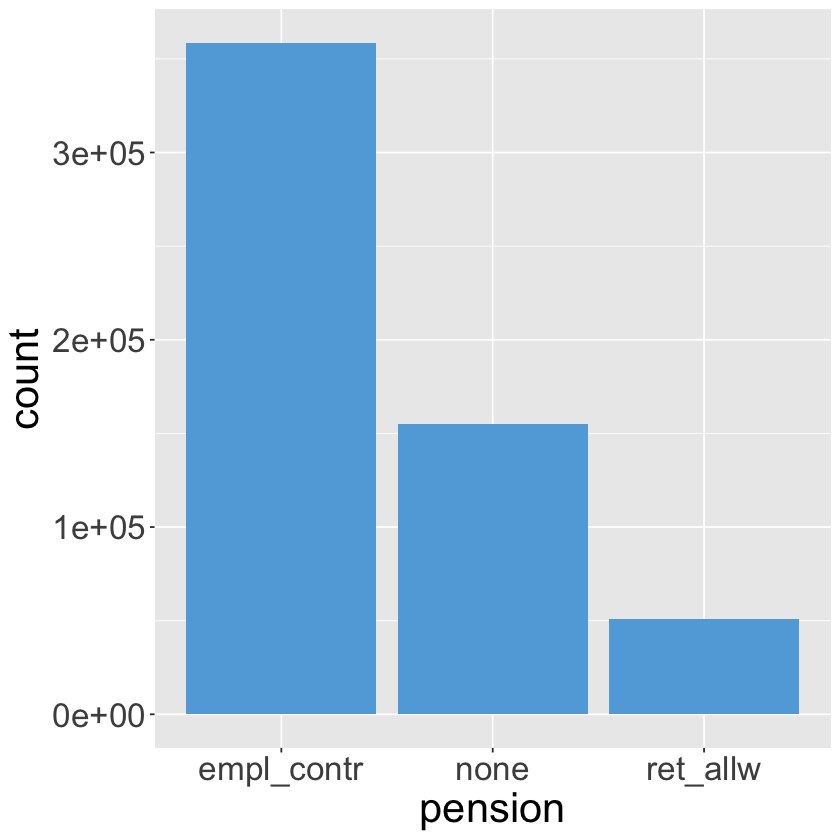

In [88]:
ggplot(data=train, aes(pension)) +
geom_histogram(stat='count', fill = "#60AADD") +
theme(text = element_text(size = 25)) 

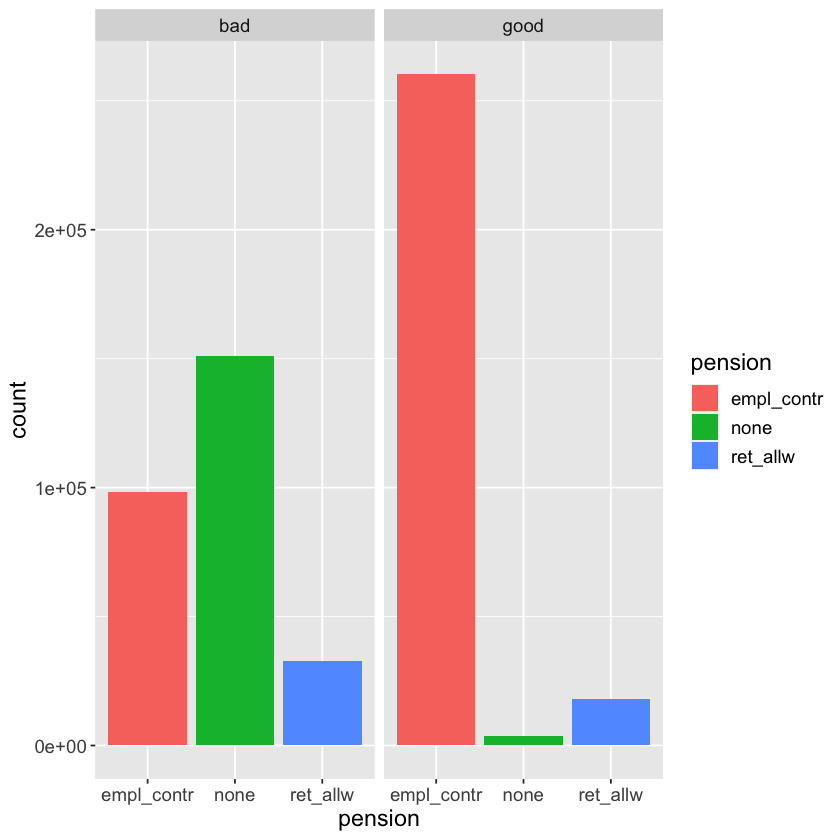

In [89]:
train %>% 
    ggplot(
        aes(x= pension, fill= pension)) + 
    geom_bar() +  
    facet_wrap(~ labor.relation)+
    theme(text = element_text(size = 14))

# good relations have more empl_contr.

### 8. standby.pay 

In [90]:
summary(train$standby.pay)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -5.987   2.000   2.000   3.275   2.000  17.458 

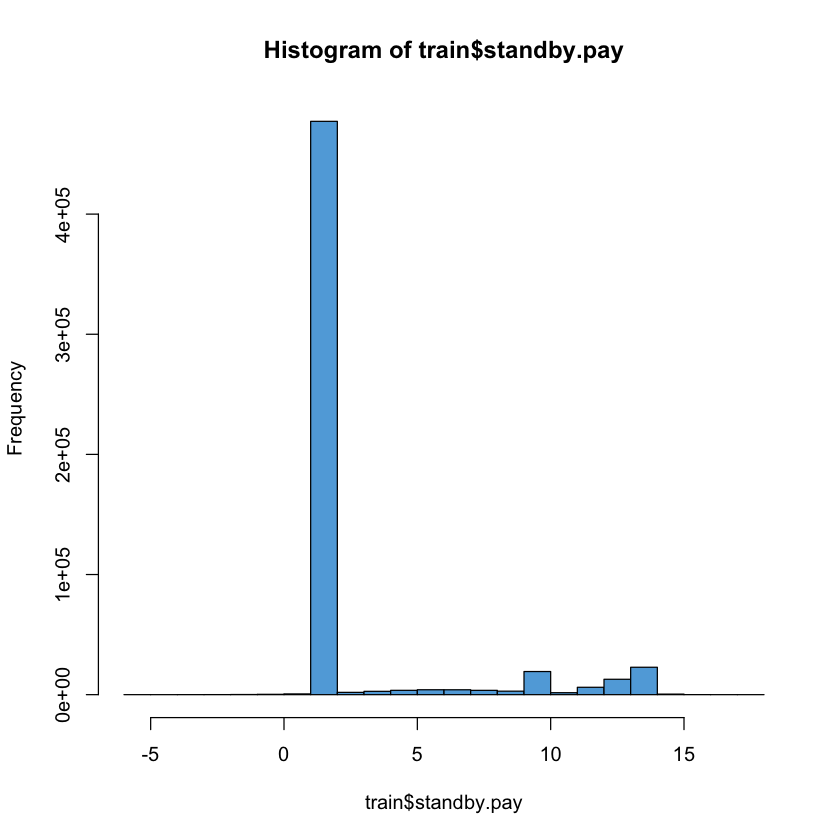

In [91]:
hist(train$standby.pay, col = "#60AADD")

In [92]:
print(paste("skewness: ", skewness(train$standby.pay)))
print(paste("kurtosis: ", kurtosis(train$standby.pay)))

[1] "skewness:  2.38151348134849"
[1] "kurtosis:  7.10201634305152"


In [93]:
wilcox.test(train$standby.pay ~ train$labor.relation, 
                mu=0,
                alternative = "two.sided",
                conf.level= 0.95,
                var.equal = F)


	Wilcoxon rank sum test with continuity correction

data:  train$standby.pay by train$labor.relation
W = 3.7656e+10, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [94]:
train %>%
    group_by(labor.relation) %>% 
    summarise(mean = mean(standby.pay), sd = sd(standby.pay),
                    median = median(standby.pay), IQR = IQR(standby.pay))

labor.relation,mean,sd,median,IQR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
bad,2.955070,2.806316,2,0
good,3.593944,3.668971,2,0


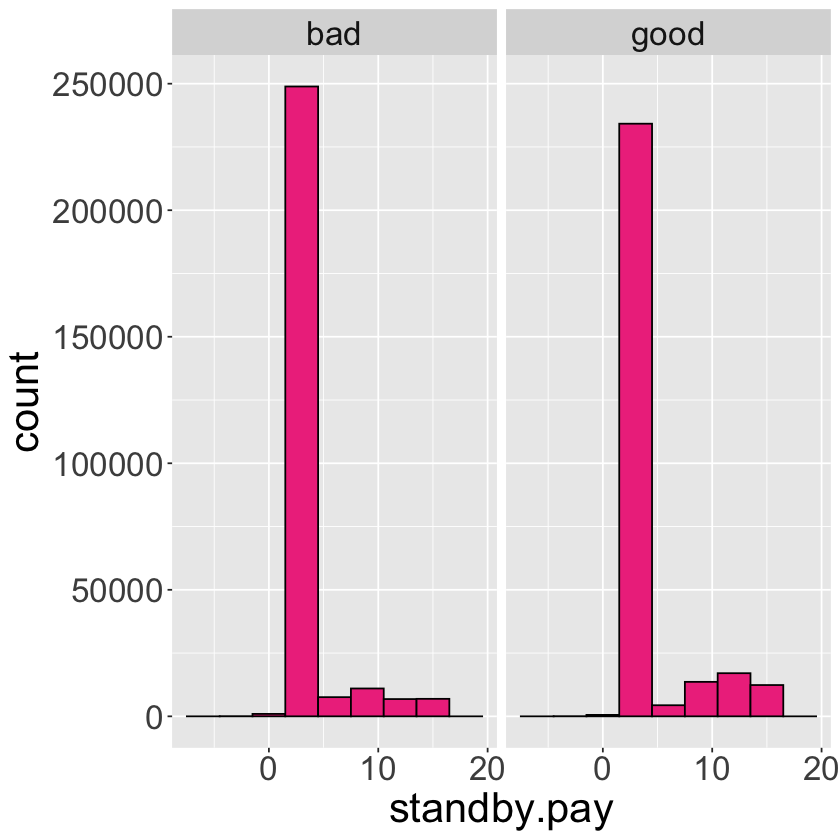

In [95]:
train %>% 
    ggplot(
        aes(x= standby.pay, fill= standby.pay)) + 
    geom_histogram(binwidth = 3, color ="black", fill = "violetred2") + 
    facet_wrap(~ labor.relation)+
    theme(text = element_text(size = 25))

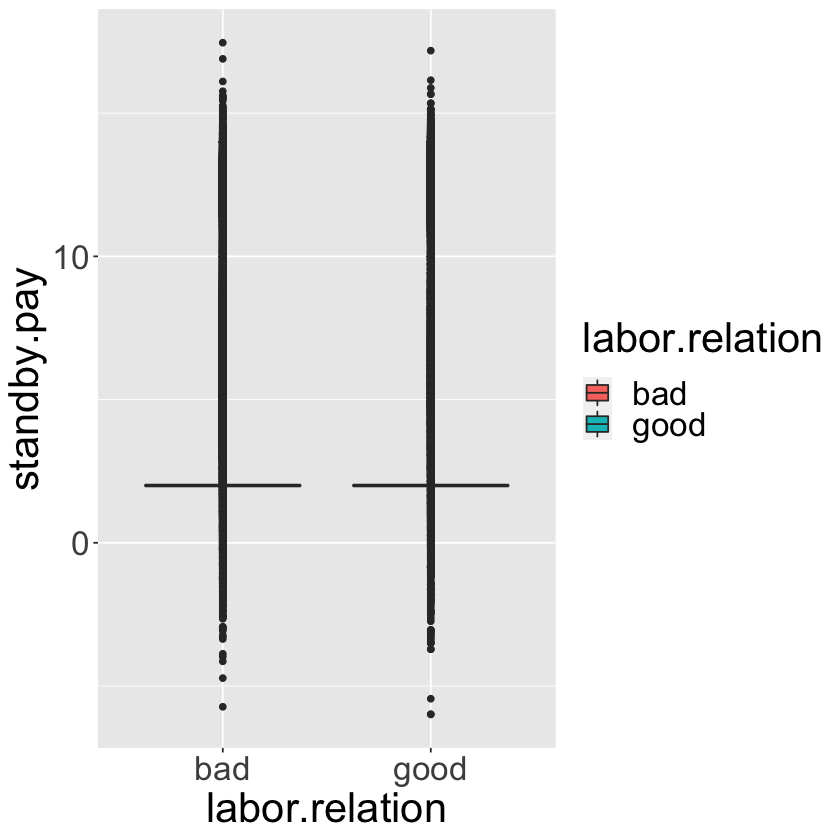

In [96]:
ggplot(train, aes(labor.relation, standby.pay, fill=labor.relation)) + 
geom_boxplot() +
theme(text = element_text(size = 25))

### 9. shift.differential

In [97]:
summary(train$shift.differential)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-23.266   3.000   3.000   4.088   4.000  43.823 

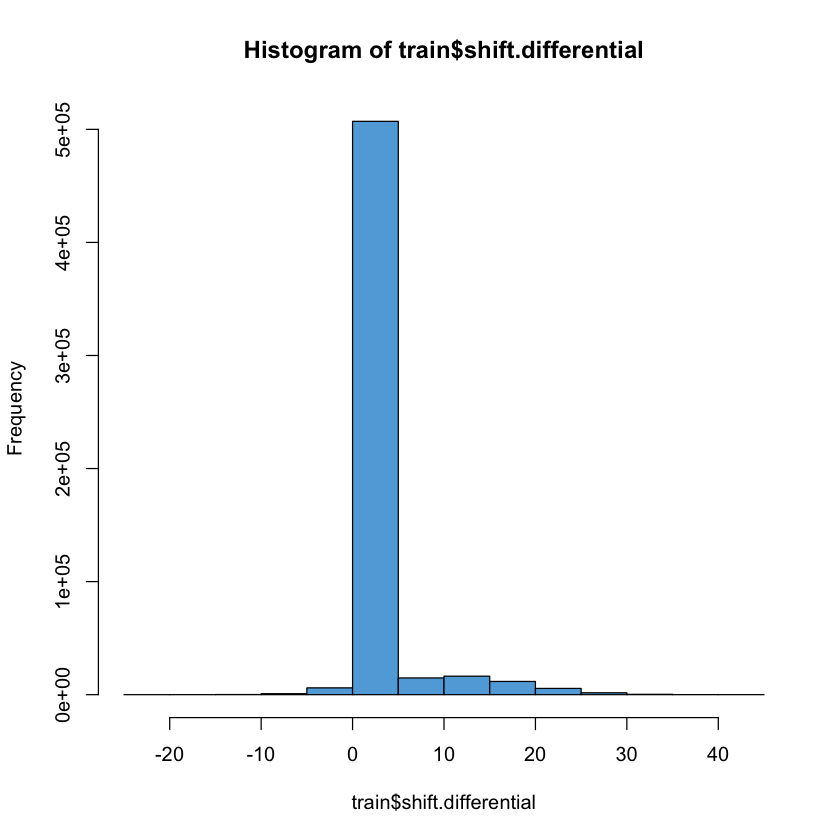

In [98]:
hist(train$shift.differential, col = "#60AADD")

In [99]:
print(paste("skewness: ", skewness(train$shift.differential)))
print(paste("kurtosis: ", kurtosis(train$shift.differential)))

[1] "skewness:  3.37657134150987"
[1] "kurtosis:  17.4335272580922"


In [100]:
wilcox.test(train$shift.differential ~ train$labor.relation, mu=0,
            alternative = "two.sided",
conf.level= 0.95,
            var.equal = F)


	Wilcoxon rank sum test with continuity correction

data:  train$shift.differential by train$labor.relation
W = 3.1063e+10, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [101]:
train %>%
    group_by(labor.relation) %>% 
    summarise(mean = mean(shift.differential), sd = sd(shift.differential),
                    median = median(shift.differential), IQR = IQR(shift.differential))

labor.relation,mean,sd,median,IQR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
bad,3.617797,3.088029,3,0
good,4.557992,4.138497,3,2


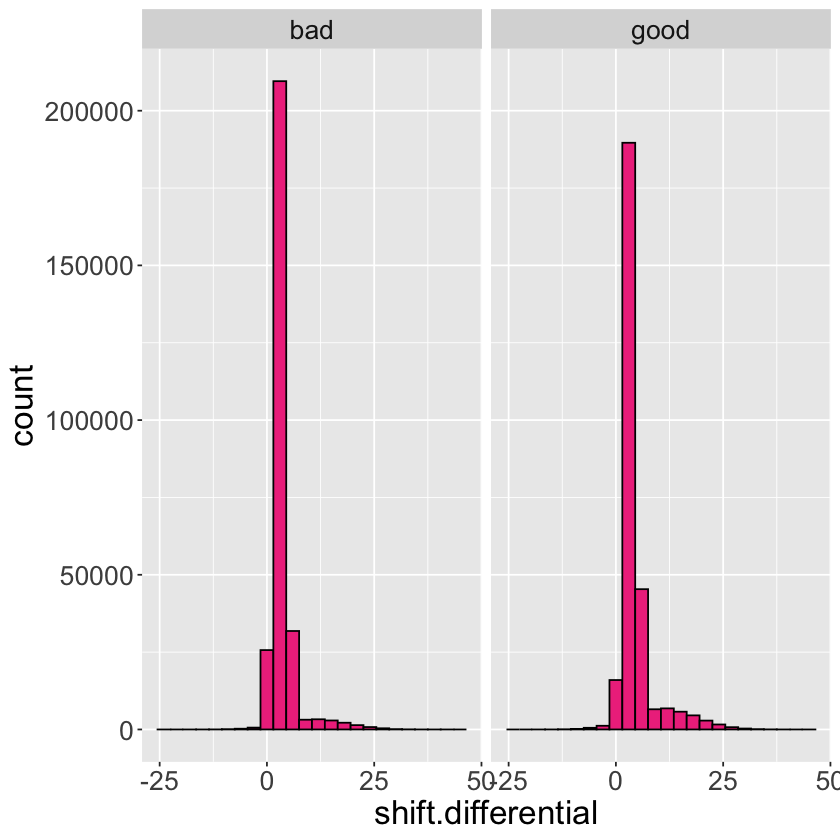

In [102]:
train %>% 
    ggplot(
        aes(x= shift.differential, fill= shift.differential)) + 
    geom_histogram(binwidth = 3, color ="black", fill = "violetred2") + 
    facet_wrap(~ labor.relation)+
    theme(text = element_text(size = 20))

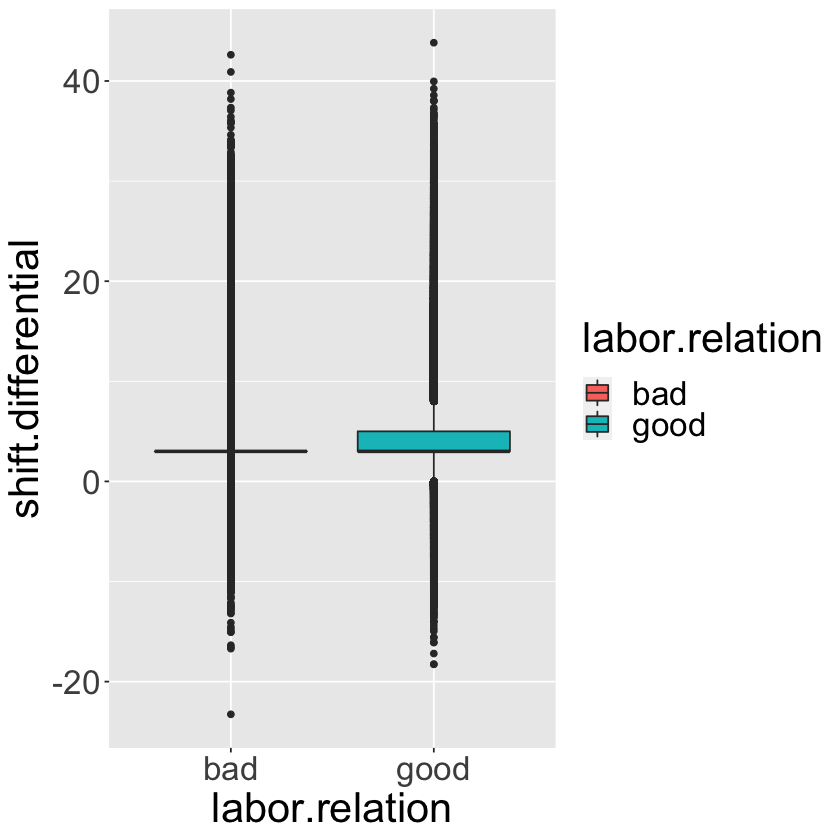

In [103]:
ggplot(train, aes(labor.relation, shift.differential, fill=labor.relation)) + 
geom_boxplot() +
theme(text = element_text(size = 25))

### 10. education.allowance

In [104]:
summary(as.factor(train$education.allowance))

0      1 
433651 130823

In [105]:
chisq.test(train$labor.relation, as.factor(train$education.allowance),
               correct = F)


	Pearson's Chi-squared test

data:  train$labor.relation and as.factor(train$education.allowance)
X-squared = 251.84, df = 1, p-value < 2.2e-16


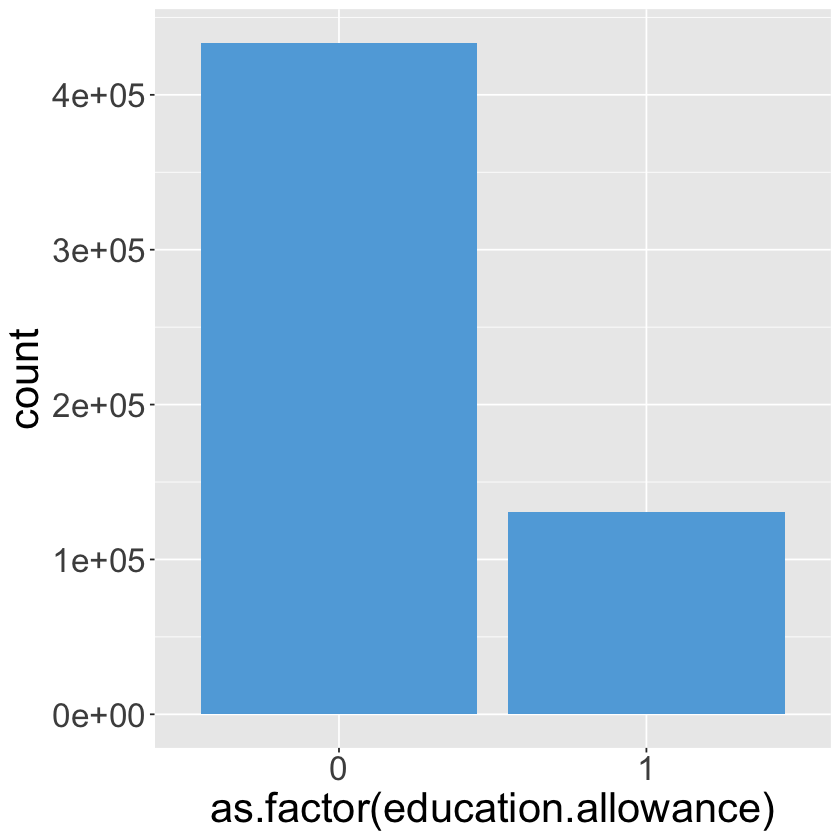

In [106]:
ggplot(data=train, aes(as.factor(education.allowance))) +
geom_histogram(stat='count', fill = "#60AADD") +
theme(text = element_text(size = 25))

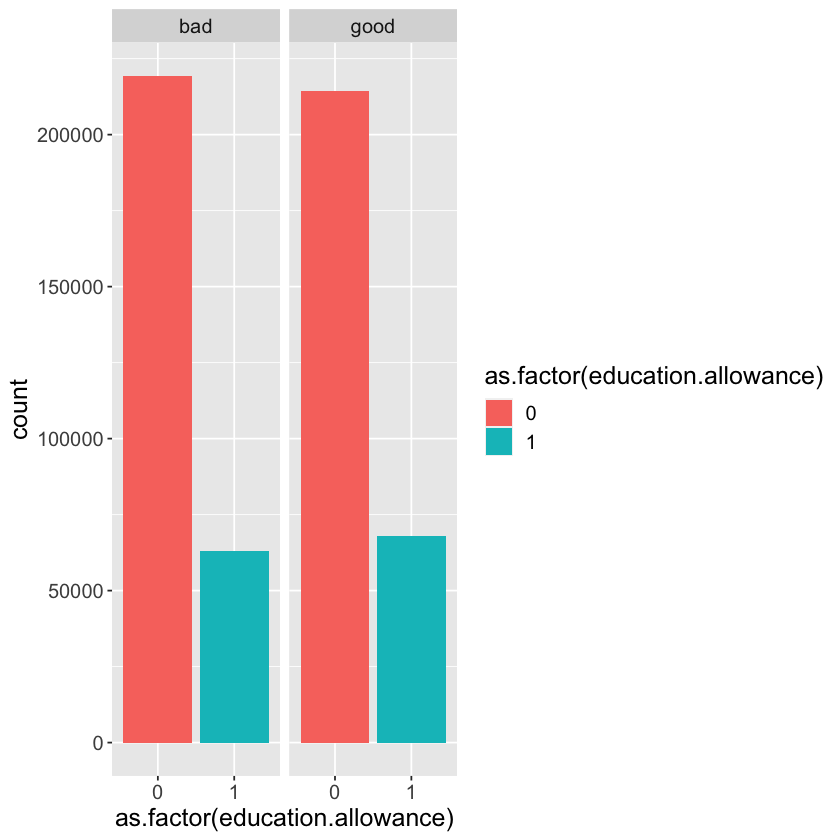

In [107]:
train %>% 
    ggplot(
        aes(x= as.factor(education.allowance), fill= as.factor(education.allowance))) + 
    geom_bar() +
    facet_wrap(~ labor.relation) +
    theme(text = element_text(size = 15))

### 11. statutory.holidays

In [108]:
summary(train$statutory.holidays)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  7.669  10.198  11.000  11.215  12.000  15.000 

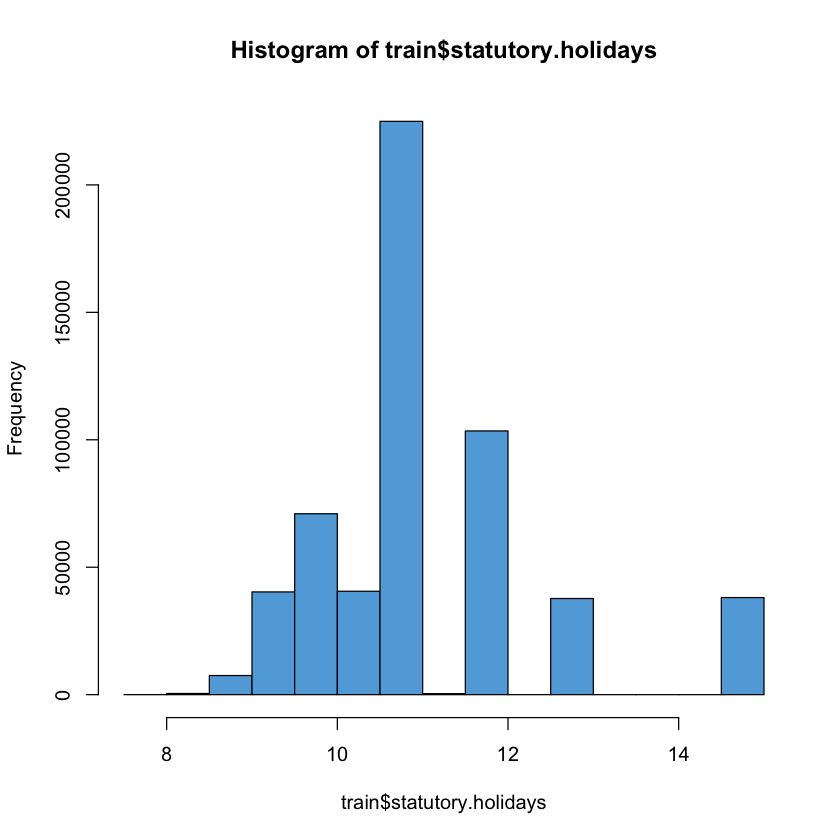

In [109]:
hist(train$statutory.holidays, col = "#60AADD")

In [110]:
print(paste("skewness: ", skewness(train$statutory.holidays)))
print(paste("kurtosis: ", kurtosis(train$statutory.holidays)))

[1] "skewness:  1.02782530680693"
[1] "kurtosis:  4.15890694466033"


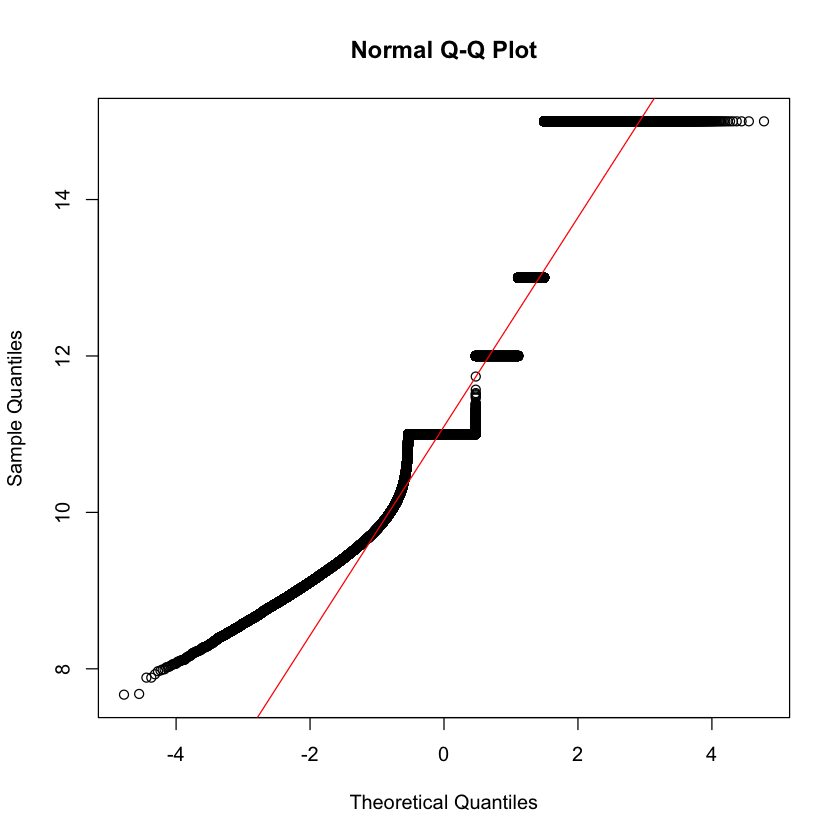

In [111]:
qqnorm(train$statutory.holidays)
qqline(train$statutory.holidays, col='red')

In [112]:
wilcox.test(train$statutory.holidays ~ train$labor.relation, mu=0,
            alternative = "two.sided",
conf.level= 0.95,
            var.equal = F)


	Wilcoxon rank sum test with continuity correction

data:  train$statutory.holidays by train$labor.relation
W = 2.5561e+10, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [113]:
train %>%
    group_by(labor.relation) %>% 
    summarise(mean = mean(statutory.holidays), sd = sd(statutory.holidays),
                    median = median(statutory.holidays), IQR = IQR(statutory.holidays))

labor.relation,mean,sd,median,IQR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
bad,10.84578,1.408193,11,1.221874
good,11.58517,1.326620,11,1.000000


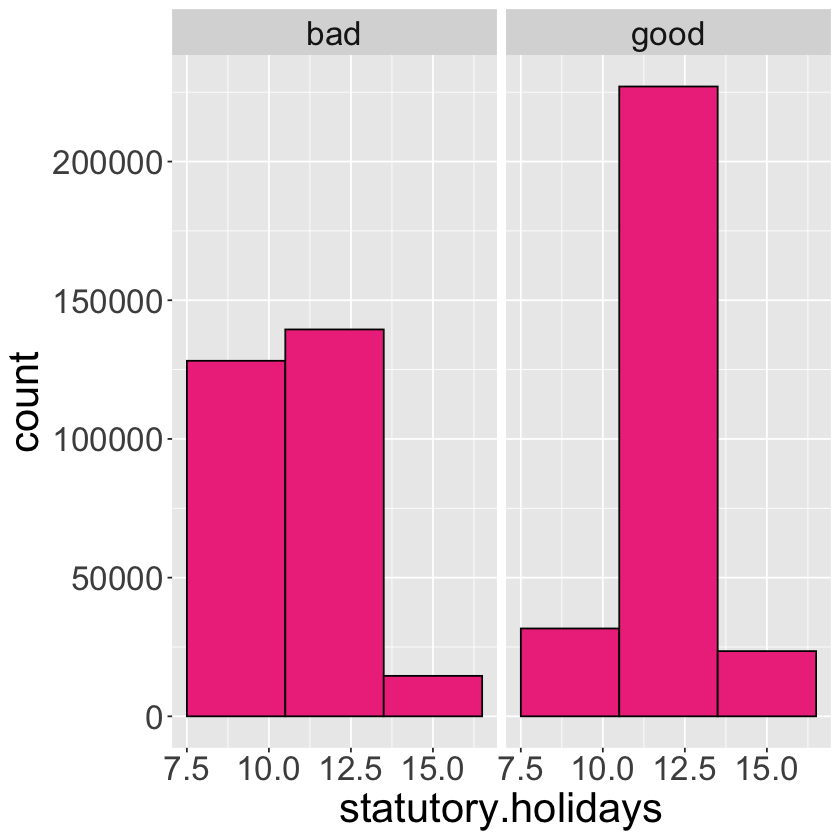

In [114]:
train %>% 
    ggplot(
        aes(x= statutory.holidays, fill= statutory.holidays)) + 
    geom_histogram(binwidth = 3, color ="black", fill = "violetred2") + 
    facet_wrap(~ labor.relation)+
    theme(text = element_text(size = 25))

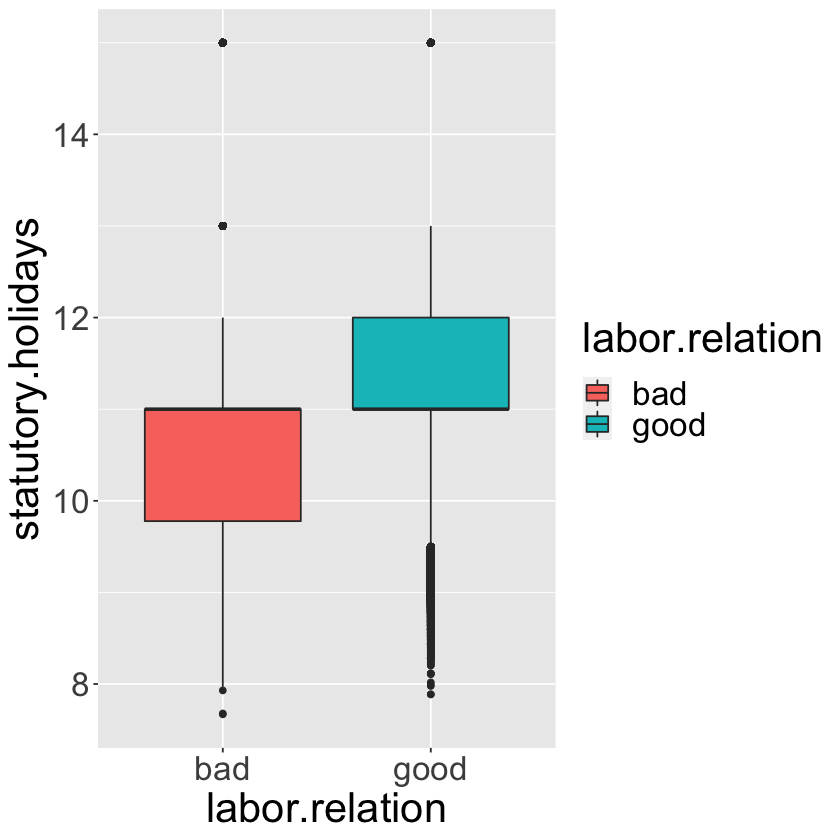

In [115]:
ggplot(train, aes(labor.relation, statutory.holidays, fill=labor.relation)) + 
geom_boxplot() +
theme(text = element_text(size = 25))

### 12. vacation 

In [116]:
summary(as.factor(train$vacation))

1      2      3 
183611 238919 141944

In [117]:
chisq.test(train$labor.relation, as.factor(train$vacation),
               correct = F)


	Pearson's Chi-squared test

data:  train$labor.relation and as.factor(train$vacation)
X-squared = 29906, df = 2, p-value < 2.2e-16


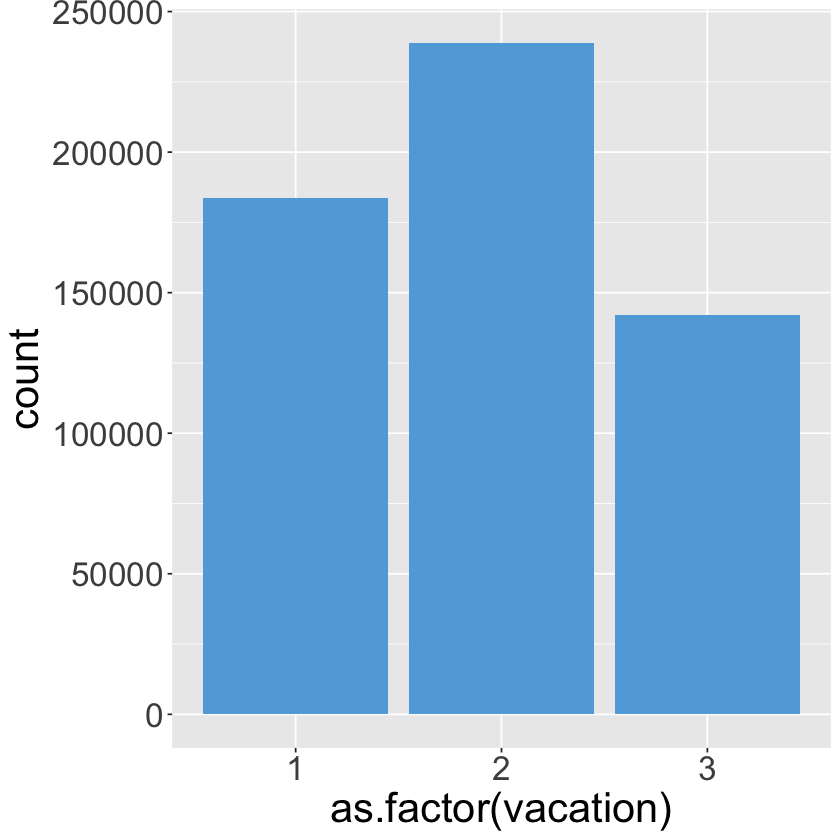

In [118]:
ggplot(data=train, aes(as.factor(vacation))) +
geom_histogram(stat='count', fill = "#60AADD") +
theme(text = element_text(size = 25))

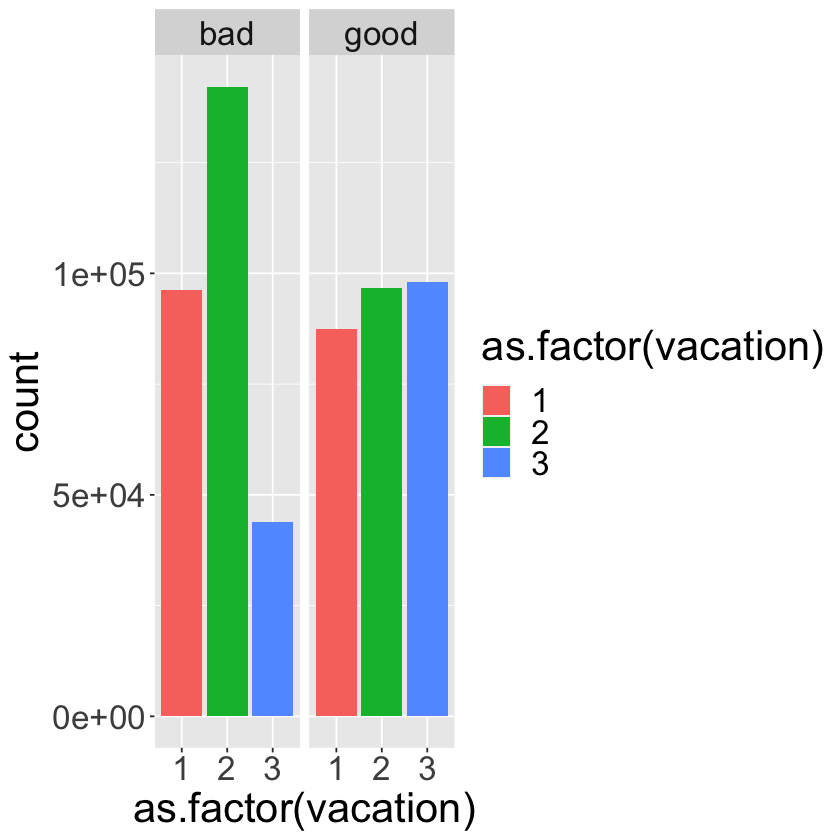

In [119]:
train %>% 
    ggplot(
        aes(x= as.factor(vacation), fill= as.factor(vacation))) + 
    geom_bar() +  
    facet_wrap(~ labor.relation) +
    theme(text = element_text(size = 25))

### 13. longterm.disability.assistance

In [120]:
summary(as.factor(train$longterm.disability.assistance))

0      1 
118034 446440

In [121]:
chisq.test(train$labor.relation, as.factor(train$longterm.disability.assistance),
               correct = F)


	Pearson's Chi-squared test

data:  train$labor.relation and as.factor(train$longterm.disability.assistance)
X-squared = 130334, df = 1, p-value < 2.2e-16


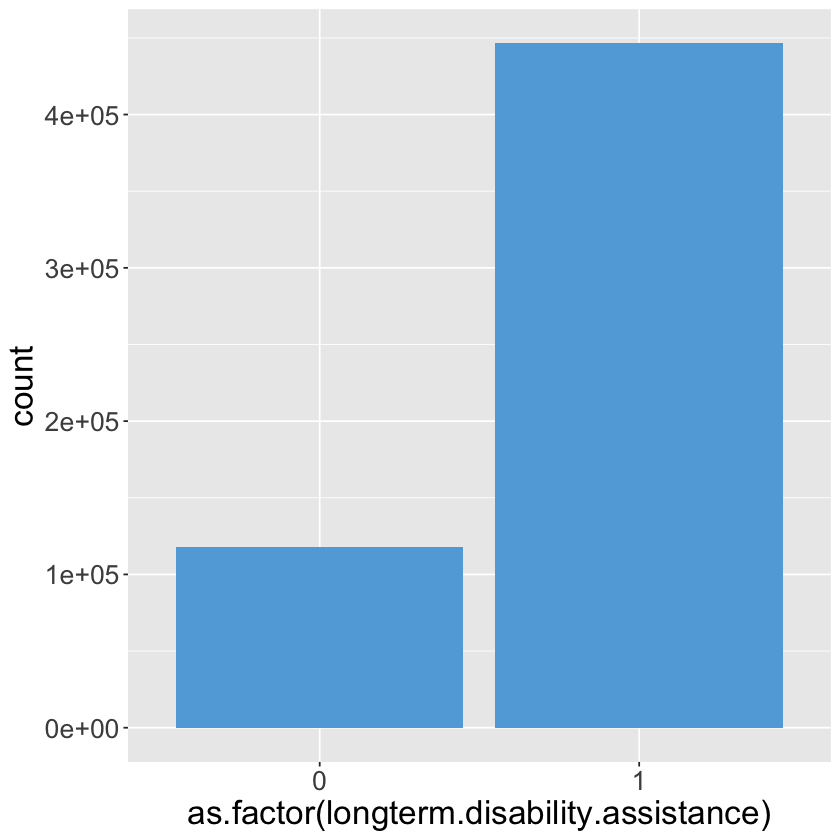

In [122]:
ggplot(data=train, aes(as.factor(longterm.disability.assistance))) +
geom_histogram(stat='count', fill = "#60AADD") +
theme(text = element_text(size = 20))

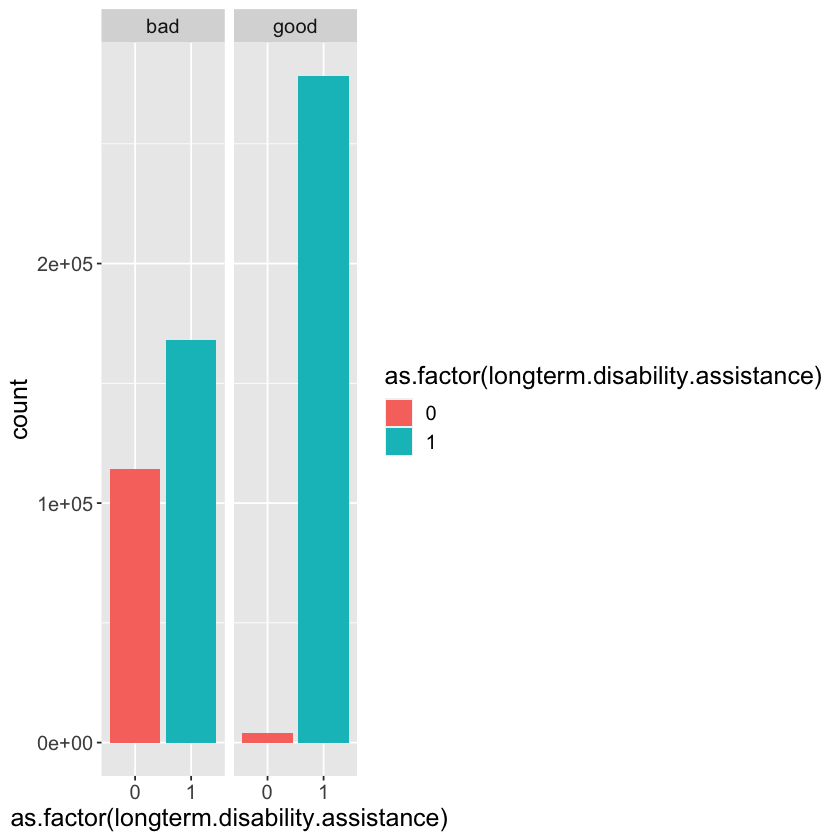

In [123]:
train %>% 
    ggplot(
        aes(x= as.factor(longterm.disability.assistance), fill= as.factor(longterm.disability.assistance))) + 
    geom_bar() +  
    facet_wrap(~ labor.relation) +
    theme(text = element_text(size = 15))

### 14. contribution.to.dental.plan

In [125]:
summary(as.factor(train$contribution.to.dental.plan))

0      1      2 
124588 330160 109726

In [126]:
chisq.test(train$labor.relation, as.factor(train$contribution.to.dental.plan),
               correct = F)


	Pearson's Chi-squared test

data:  train$labor.relation and as.factor(train$contribution.to.dental.plan)
X-squared = 115621, df = 2, p-value < 2.2e-16


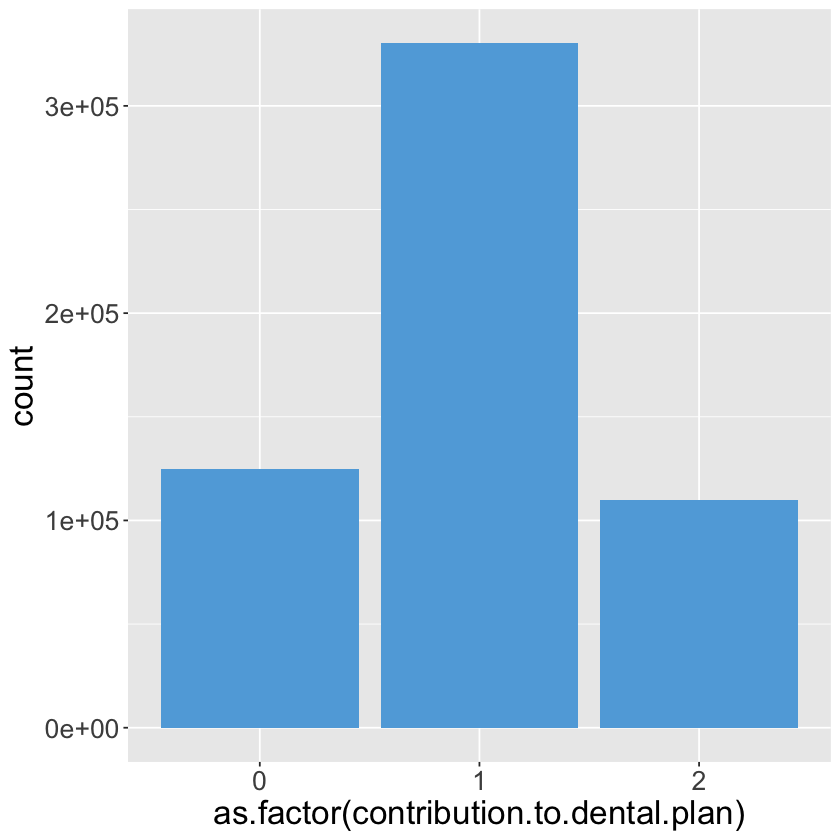

In [127]:
ggplot(data=train, aes(as.factor(contribution.to.dental.plan))) +
geom_histogram(stat='count', fill = "#60AADD") +
theme(text = element_text(size = 20))

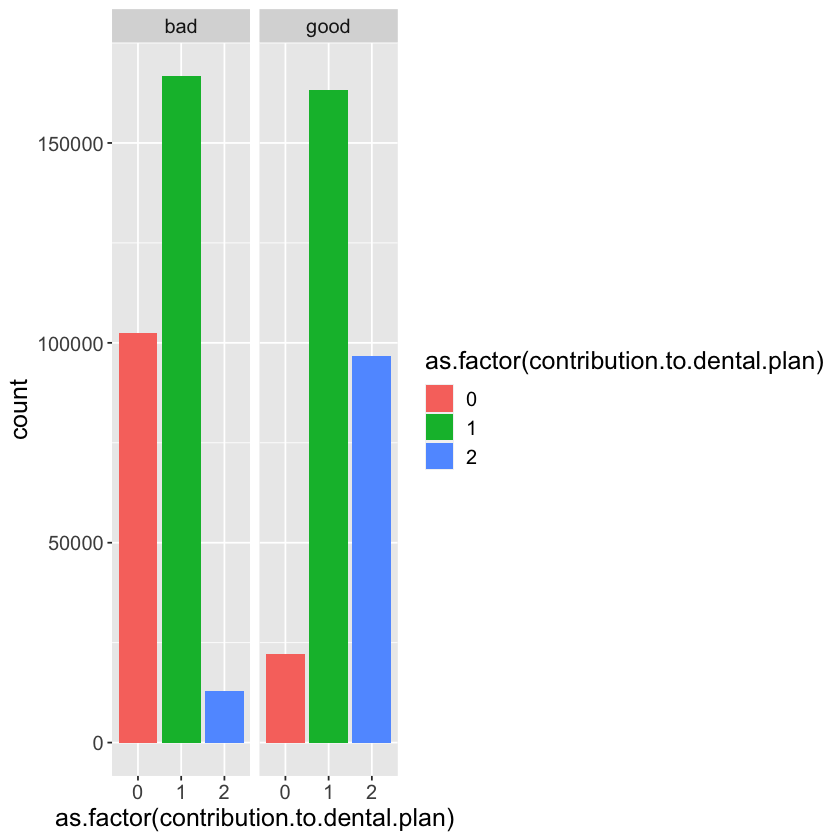

In [128]:
train %>% 
    ggplot(
        aes(x= as.factor(contribution.to.dental.plan), fill= as.factor(contribution.to.dental.plan))) + 
    geom_bar() +  
    facet_wrap(~ labor.relation) +
    theme(text = element_text(size = 15))

### 15. bereavement.assistance

In [129]:
summary(as.factor(train$bereavement.assistance))

0      1 
 56535 507939

In [130]:
chisq.test(train$labor.relation, as.factor(train$bereavement.assistance),
               correct = F)


	Pearson's Chi-squared test

data:  train$labor.relation and as.factor(train$bereavement.assistance)
X-squared = 40407, df = 1, p-value < 2.2e-16


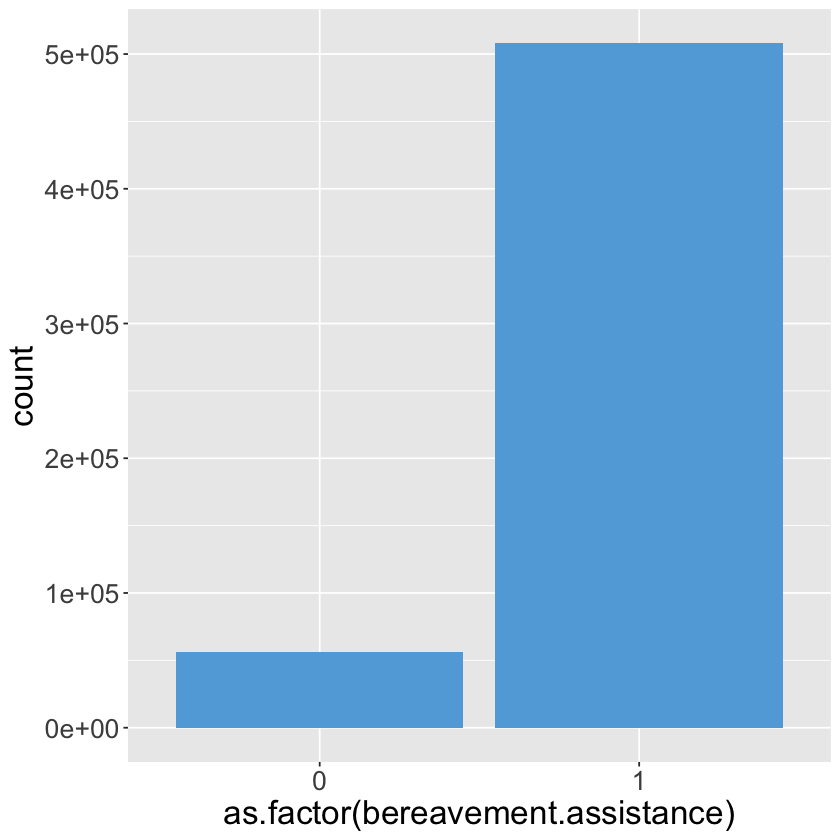

In [131]:
ggplot(data=train, aes(as.factor(bereavement.assistance))) +
geom_histogram(stat='count', fill = "#60AADD") +
theme(text = element_text(size = 20))

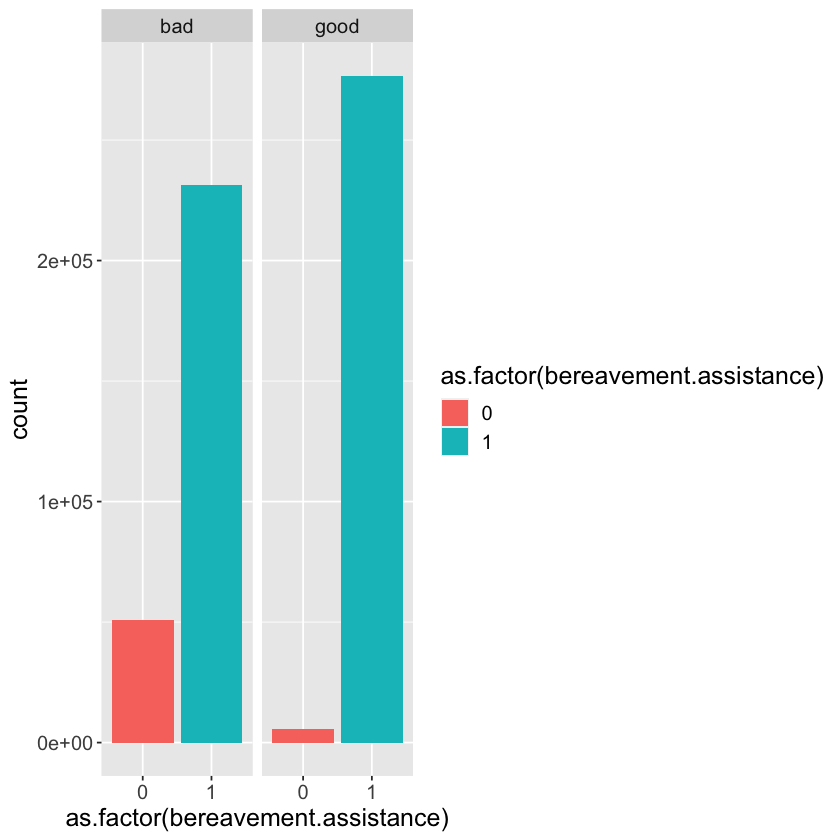

In [132]:
train %>% 
    ggplot(
        aes(x= as.factor(bereavement.assistance), fill= as.factor(bereavement.assistance))) + 
    geom_bar() +  
    facet_wrap(~ labor.relation) +
    theme(text = element_text(size = 15))

### 16. contribution.to.health.plan

In [133]:
summary(as.factor(train$contribution.to.health.plan))

0      1      2 
 96965 116051 351458

In [134]:
chisq.test(train$labor.relation, as.factor(train$contribution.to.health.plan),
               correct = F)


	Pearson's Chi-squared test

data:  train$labor.relation and as.factor(train$contribution.to.health.plan)
X-squared = 74106, df = 2, p-value < 2.2e-16


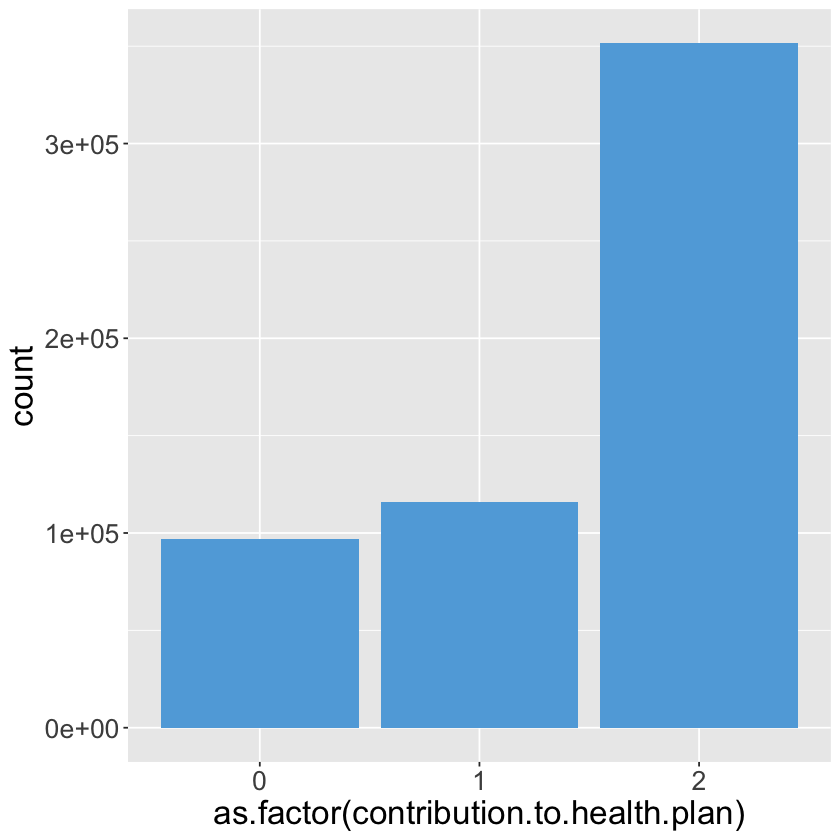

In [135]:
ggplot(data=train, aes(as.factor(contribution.to.health.plan))) +
geom_histogram(stat='count', fill = "#60AADD") +
theme(text = element_text(size = 20))

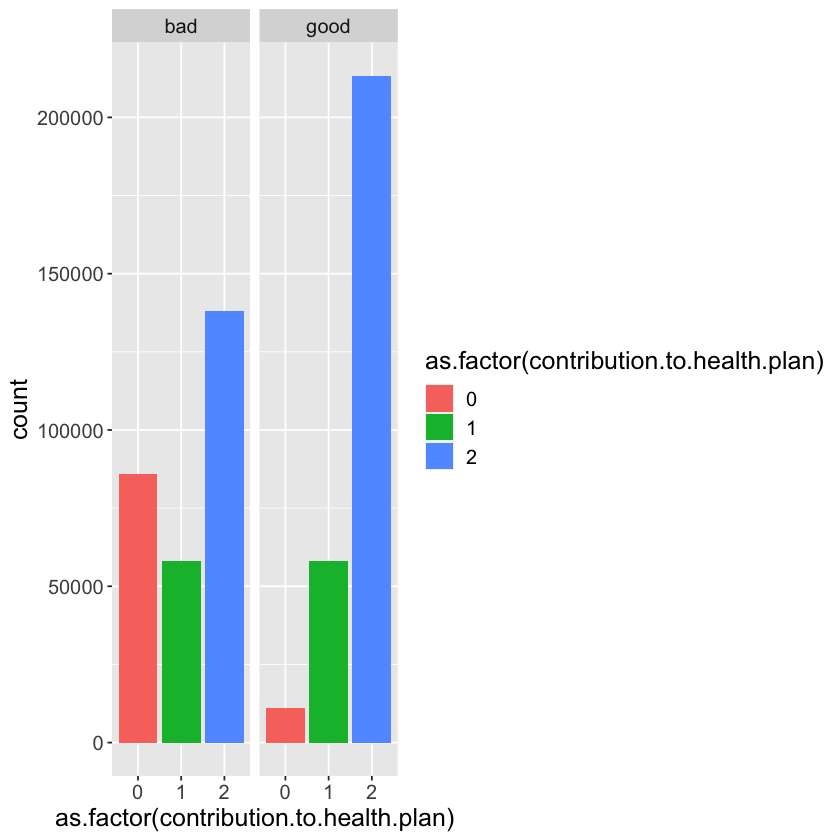

In [136]:
train %>% 
    ggplot(
        aes(x= as.factor(contribution.to.health.plan), fill= as.factor(contribution.to.health.plan))) + 
    geom_bar() +  
    facet_wrap(~ labor.relation) +
    theme(text = element_text(size = 15))

In [224]:
#train$total.wage.increase = train$wage.increase.first.year + train$wage.increase.second.year + train$wage.increase.third.year

In [144]:
str(train)

'data.frame':	564474 obs. of  18 variables:
 $ duration                      : int  3 2 1 1 3 3 2 1 2 3 ...
 $ wage.increase.first.year      : num  2.01 7.25 1.97 2.07 4.01 ...
 $ wage.increase.second.year     : num  3.38 4 4.46 3.05 4 ...
 $ wage.increase.third.year      : num  2.11 5 5 5 5 ...
 $ cost.of.living.adjustment     : Factor w/ 3 levels "none","tc","tcf": 3 1 1 1 1 1 1 1 1 1 ...
 $ working.hours                 : num  40 40 40 40 39.1 ...
 $ pension                       : Factor w/ 3 levels "empl_contr","none",..: 2 3 1 3 1 1 2 1 2 1 ...
 $ standby.pay                   : num  2 2 5.29 2 2 ...
 $ shift.differential            : num  0.839 3 2.603 3 3 ...
 $ education.allowance           : int  0 1 0 0 0 0 1 1 0 0 ...
 $ statutory.holidays            : num  9.44 9.9 11 11 12 ...
 $ vacation                      : int  2 2 3 2 2 1 3 1 1 3 ...
 $ longterm.disability.assistance: int  0 1 0 1 1 1 1 1 0 1 ...
 $ contribution.to.dental.plan   : int  1 0 0 0 2 1 0 0 1 2 ...
 $ ber

### Features importance

In [120]:
#remove labor.relation
drop <- c("labor.relation") 
train1 <- train[,!(names(train) %in% drop)]
test1 <- test[,!(names(test) %in% drop)]

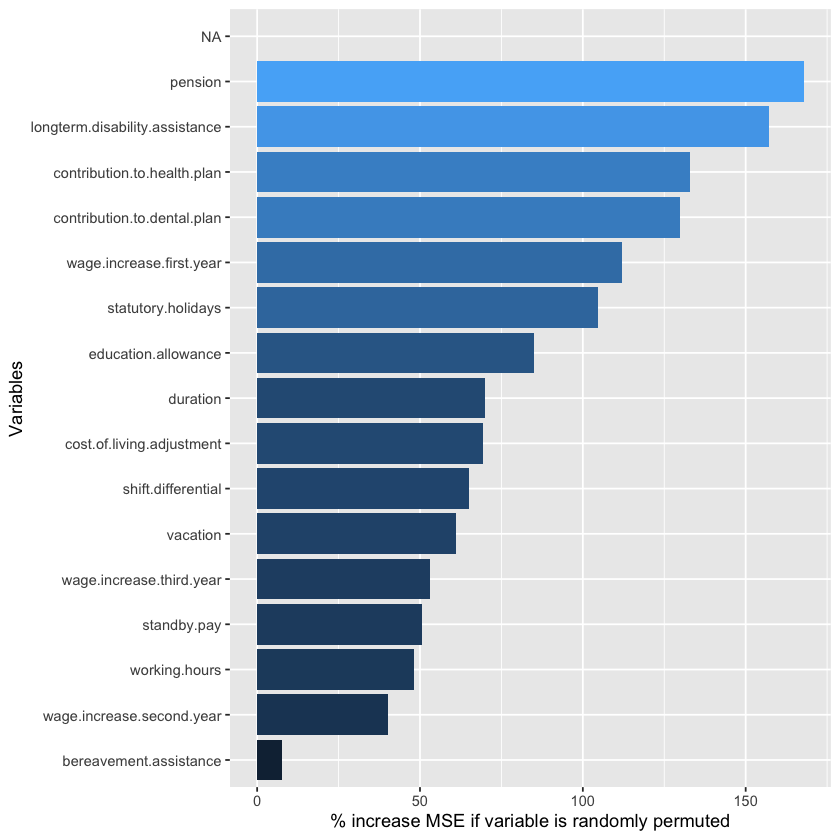

In [162]:
# set.seed(1206)
# quick_RF <- randomForest(x=train1[, 1:16], y=train1$class, ntree=20, importance=TRUE)
# imp_RF <- importance(quick_RF)
# imp_DF <- data.frame(Variables = row.names(imp_RF), MSE = imp_RF[,1])
# imp_DF <- imp_DF[order(imp_DF$MSE, decreasing = TRUE),]

# ggplot(imp_DF[1:20,], aes(x=reorder(Variables, MSE), y=MSE, fill=MSE)) + geom_bar(stat = 'identity') + labs(x = 'Variables', y= '% increase MSE if variable is randomly permuted') + coord_flip() + theme(legend.position="none")

In [ ]:
# drop wage.increase.third.year: low importance, high corrleation with wage.increase.first.year, 
    #which has higher corrletaion with the response variable and higher importance.
# drop bereavement.assistance, lowest importance, also has high corrleation with longterm.disability.assistance, 
    #which has higher correlation with the response variable and higher importance.

### Feature engineering

In [121]:
numericVarNames = names(data[,sapply(train, is.numeric)])

train1_numeric <- train1[, names(train1) %in% numericVarNames]
train1_factor <- train1[, !names(train1) %in% numericVarNames]
test1_numeric <- test1[, names(test1) %in% numericVarNames]
test1_factor <- test1[, !names(test1) %in% numericVarNames]

train1_dummy <- as.data.frame(model.matrix(~.-1, train1_factor))
test1_dummy <- as.data.frame(model.matrix(~.-1, test1_factor))

train2 <- cbind(train1_numeric, train1_dummy)
test2 <- cbind(test1_numeric, test1_dummy)

In [78]:
#skewness

# for(i in 1:ncol(train1_numeric)){
#         if (abs(skewness(train1_numeric[,i]))>0.8){
#                 train1_numeric[,i] <- log(train1_numeric[,i] +1)
#         }
# }

# for(i in 1:ncol(test1_numeric)){
#         if (abs(skewness(test1_numeric[,i]))>0.8){
#                 test1_numeric[,i] <- log(test1_numeric[,i] +1)
#         }
# }

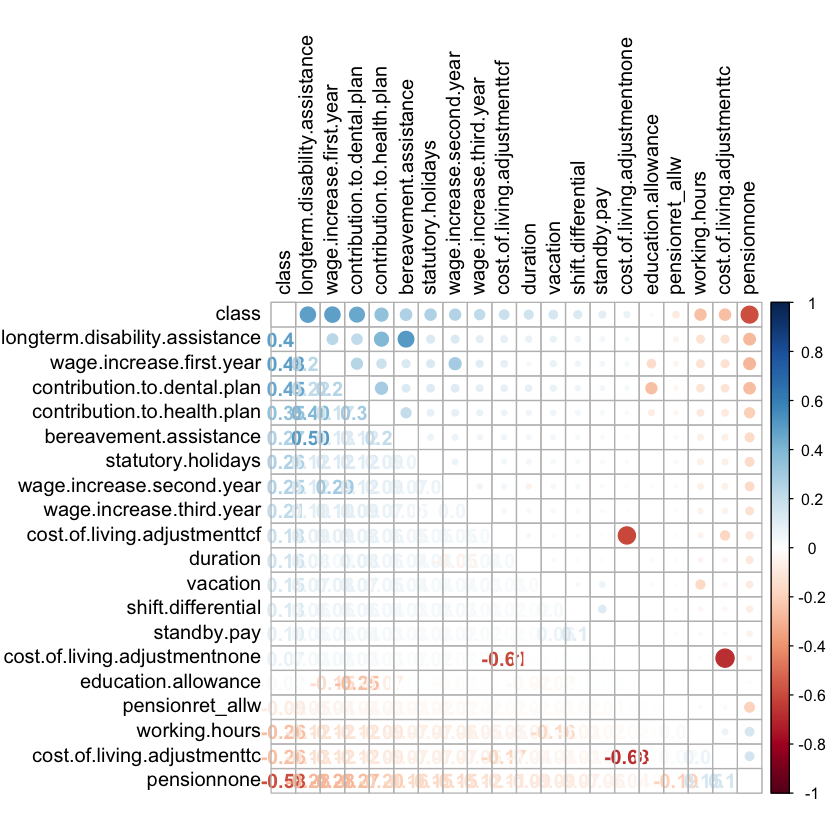

In [122]:
cor_numVar <- cor(train2, use="pairwise.complete.obs") #correlations of all numeric variables

cor_sorted <- as.matrix(sort(cor_numVar[,'class'], decreasing = TRUE))
CorHigh <- names(which(apply(cor_sorted, 1, function(x) abs(x)>0)))
cor_numVar <- cor_numVar[CorHigh, CorHigh]

corrplot.mixed(cor_numVar, tl.col="black", tl.pos = "lt")

In [123]:
# remove cost.of.living.adjustmentnone
drop <- c("cost.of.living.adjustmentnone") 
train2 <- train2[,!(names(train2) %in% drop)]
test2 <- test2[,!(names(test2) %in% drop)]

In [124]:
set.seed(43)
model <- lm(class ~., data = train2)
# Make predictions
predictions <- model %>% predict(test2)
# Model performance
data.frame(
  RMSE = RMSE(predictions, test2$class),
  R2 = R2(predictions, test2$class)
)

RMSE,R2
<dbl>,<dbl>
0.2791318,0.669856


In [86]:
vif(model)

duration       wage.increase.first.year 
                      1.023254                       1.267535 
     wage.increase.second.year       wage.increase.third.year 
                      1.113221                       1.030058 
                 working.hours                    standby.pay 
                      1.066700                       1.020327 
            shift.differential            education.allowance 
                      1.022416                       1.100909 
            statutory.holidays                       vacation 
                      1.047064                       1.039599 
longterm.disability.assistance    contribution.to.dental.plan 
                      1.629350                       1.283872 
        bereavement.assistance    contribution.to.health.plan 
                      1.339642                       1.264720 
   cost.of.living.adjustmenttc   cost.of.living.adjustmenttcf 
                      1.067857                       1.044411 
                   pensionnone                pensionret_allw 
                      1.324587                       1.071780

In [87]:
summary(model)


Call:
lm(formula = class ~ ., data = train2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.39420 -0.17941  0.03617  0.20499  1.15561 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -0.2726798  0.0082550  -33.03   <2e-16 ***
duration                        0.0521341  0.0005531   94.26   <2e-16 ***
wage.increase.first.year        0.0802760  0.0003272  245.37   <2e-16 ***
wage.increase.second.year       0.0270177  0.0003623   74.57   <2e-16 ***
wage.increase.third.year        0.0419854  0.0004091  102.63   <2e-16 ***
working.hours                  -0.0186651  0.0001712 -109.03   <2e-16 ***
standby.pay                     0.0042107  0.0001192   35.33   <2e-16 ***
shift.differential              0.0056190  0.0001064   52.83   <2e-16 ***
education.allowance             0.1221468  0.0009629  126.86   <2e-16 ***
statutory.holidays              0.0350742  0.0002796  125.44   <2e-16 ***
vacation             

In [88]:
set.seed(43)
glm_train_2 <- glm(class~.,data=train2,family=binomial())

glm_test <- predict(glm_train_2, test2, type =  "response")

require(ROCR)
glm_auc_1<-prediction(glm_test, test2$class)
glm_prf<-performance(glm_auc_1, measure="tpr", x.measure="fpr")
glm_slot_fp<-slot(glm_auc_1,"fp")
glm_slot_tp<-slot(glm_auc_1,"tp")
glm_fpr3<-unlist(glm_slot_fp)/unlist(slot(glm_auc_1,"n.neg"))
glm_tpr3<-unlist(glm_slot_tp)/unlist(slot(glm_auc_1,"n.pos"))
glm_perf_AUC=performance(glm_auc_1,"auc")
glm_AUC=glm_perf_AUC@y.values[[1]]
print(glm_AUC)

[1] 0.9762544